Lane Following Problem
===========================

The dynamics model of an omnidirectional vehicle with no friction is defined by the following equation:

$$
\dot{p}^x(t) = (v_k + \dot{v}_k(t-T_s k))cos(\theta_k + \theta_k(t - T_sk))
$$
$$
\dot{p}^y(t) = (v_k + \dot{v}_k(t - T_s k))sin(\theta_k + \theta_k(t - T_s k))
$$

iLQR is applied to a vehicle in order to control them to follow a reference trajectory at a terminal velocity of $10 m/s$.

The state vector $\textbf{x}$ is defined as follows:
$$\begin{equation*}
\textbf{x} = \begin{bmatrix}
    p^x & p^y & v & \theta
    \end{bmatrix}^T
\end{equation*}$$

The action vector $\textbf{u}$ is defined as follows:
$$\begin{equation*}
\textbf{u} = \begin{bmatrix}
   \dot{v} & \delta
    \end{bmatrix}^T
\end{equation*}$$

**Note**: That since this dynamics model is nonlinear, this problem can be solved
more efficiently with a simple Linear Quadratic Regulator (LQR) instead. This
example is just used to demonstrate how to setup an auto-differentiated
dynamics model.

In [1]:
%matplotlib inline

In [2]:
from __future__ import print_function
import sys
import os
sys.path.append(os.path.abspath('../'))
import random
import ilqr
import math

In [3]:
import numpy as np
import theano.tensor as T
import matplotlib.pyplot as plt


In [4]:
from ilqr import iLQR
from ilqr.cost import PathQRCost
from ilqr.examples.car import CarDynamics, CarCost

from bc import *
import pickle

In [5]:
def on_iteration(iteration_count, xs, us, J_opt, accepted, converged):
    J_hist.append(J_opt)
    info = "converged" if converged else ("accepted" if accepted else "failed")
    final_state = xs[-1]
    final_control = us[-1]
    if iteration_count % 60 == 0:
        print("iteration", iteration_count, info, J_opt, final_state, final_control)


In [6]:
dt = 0.05
wheel_diameter = 1.0
dynamics = CarDynamics(dt, l=wheel_diameter)

An instantaneous cost function $l(\textbf{x}_t, \textbf{u}_t)$ is defined as follows:

$$
l(\textbf{x}_t, \textbf{u}_t) = \textbf{x}_t^T Q \textbf{x}_t + \textbf{u}_t^T R \textbf{u}_t
$$

where $Q$ is the state error and $R$ is the control error.

In order to approach the two vehicles to each other, $Q$ is set up to penalize differences in positions as $||\textbf{x}_0 - \textbf{x}_1||^2$ while penalizing non-zero velocities.

The following code generates the lane and boundaries. There are 150 way points along the reference trajectory. The boundary is +-3 vertically away from the reference trajecotry.S

In [7]:

def lane(posx):
    ts = [80, 90, 150]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))

'''

def nominal(posx):
    ts = [80, 90, 150]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/(1 * rate)), np.arctan(-height * np.exp((posx - ts[0])/(1 * rate)/(1 * rate)))
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1]:
        return -height * np.exp((ts[1] - posx)/(1 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(1 * rate)))


def lane(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((ts[3] - posx)/(2 * rate)))
    
def nominal(posx):
    ts = [30, 60, 90, 120]
    rate = 6.0
    height = 6.0
    if posx <= ts[0]:
        return -height * np.exp((posx - ts[0])/rate), np.arctan(-height * np.exp((posx - ts[0])/rate)/rate)
    elif posx > ts[0] and posx <= ts[1]:
        return -height * np.exp(ts[0] - ts[0]), np.arctan(0)
    elif posx > ts[1] and posx <= ts[3]:
        return -height * np.exp((ts[1] - posx)/(2 * rate)), np.arctan(+ height * np.exp((ts[1] - posx)/(2 * rate)))
    #elif posx > ts[2] and posx <= ts[3]:
    #    return -height * np.exp((posx - ts[2])/rate), np.arctan(-height * np.exp((posx - ts[2])/rate)/rate)
    elif posx > ts[3]:
        return -height * np.exp((posx - ts[3])/(2 * rate)), np.arctan(+ height * np.exp((posx - ts[3])/(2 * rate)))
'''

def barrier_u(posx):
    ts = [80, 90, 150]
    if posx <= ts[0]:
        return + 1 + posx, + 2 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[0] and posx <= ts[1]:
        return + 1 + posx, + 2 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[1]:
        return + 1 + posx, + 2 + lane(posx)[0], lane(posx)[1]
                                                                      
def barrier_l(posx):
    ts = [80, 90, 150]
    if posx <= ts[0]:
        return - 1 + posx, -2 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[0] and posx <= ts[1]:
        return - 1 + posx, -2 + lane(posx)[0], lane(posx)[1]
    elif posx > ts[1]:
        return - 1 + posx, -2 + lane(posx)[0], lane(posx)[1]
    
def nominal(posx):
    return (barrier_u(posx)[1] + barrier_l(posx)[1]) * 0.5, (barrier_u(posx)[2] + barrier_l(posx)[2]) * 0.5

  

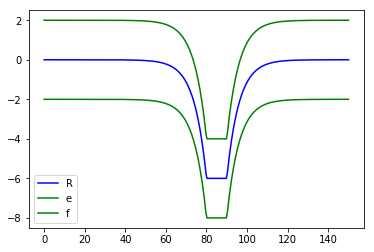

In [8]:
posx_path = np.linspace(0, 150, 300)
x_nominal = [[posx_path[i], nominal(posx_path[i])[0], 10, nominal(posx_path[i])[1]] for i in range(300)]
x_barrier_u = [[posx_path[i], barrier_u(posx_path[i])[1], 10, barrier_u(posx_path[i])[1]] for i in range(300)]
x_barrier_l = [[posx_path[i], barrier_l(posx_path[i])[1], 10, barrier_l(posx_path[i])[1]] for i in range(300)]


posx_ = np.asarray(x_nominal)[:, 0]
posy_ = np.asarray(x_nominal)[:, 1]
posy_u = np.asarray(x_barrier_u)[:, 1]
posy_l = np.asarray(x_barrier_l)[:, 1]
_ = plt.plot(posx_, posy_, "b")
_ = plt.plot(posx_, posy_u, 'g')
_ = plt.plot(posx_, posy_l, 'g')
_ = plt.legend("Reference Path")


In [24]:
n = 2
agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 100, checkpoint = 'checkpoints/mlp_H2.pt')

#agent.data_process(paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p'])
#agent.train(num_epoch = 1000)


In [25]:
def agent_run(agent, x0s):
    agent_traj = []
    for x0 in x0s:
        agent_traj.append([])
        for _ in range(0, N):
            i = abs(int(x0[0]/0.5))
            x_nn = []
            if i >= N - H - 1:
                break
            x_nominal_ = x_nominal[i: i + H]
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            agent_traj[-1] = agent_traj[-1] + [[x0[:], u[0]]]
            x1 = dynamics.f(x0, u[0], i)[0]        
            x0 = x1[:]
    return agent_traj

x0s = []
batch_size = 20
for i_batch in range(batch_size):
    x0s.append([x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 2
agent_traj = agent_run(agent, x0s)
        

print("Done")

Done


The red curve in the plot shows the trajectory of the regression model controller.

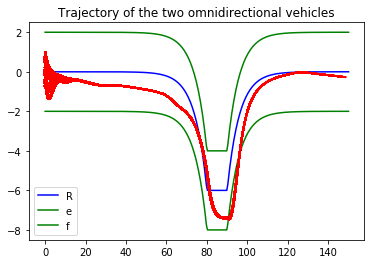

In [26]:
def draw_agent_traj(agent_trajs):
    plt.title("Trajectory of the two omnidirectional vehicles")
    plt.legend(["Vehicle", "Reference Path"])
    
    posx_ = np.asarray(x_nominal)[:, 0]
    posy_ = np.asarray(x_nominal)[:, 1]
    posy_u = np.asarray(x_barrier_u)[:, 1]
    posy_l = np.asarray(x_barrier_l)[:, 1]
    _ = plt.plot(posx_, posy_, "b")
    _ = plt.plot(posx_, posy_u, 'g')
    _ = plt.plot(posx_, posy_l, 'g')
    _ = plt.legend("Reference Path")

    posx = []
    posy = []
    v = []
    theta = []
    for agent_traj in agent_trajs:
        posx.append([])
        posy.append([])
        v.append([])
        theta.append([])
        for j in agent_traj:
            posx[-1].append(j[0][0])
            posy[-1].append(j[0][1])
            v[-1].append(j[0][2])
            theta[-1].append(j[0][3])
            plt.plot(posx[-1], posy[-1], "r")

    plt.show()

draw_agent_traj(agent_traj)

In [59]:
N = len(x_nominal)
H = 2  # Number of time steps in trajectory.
n = 30
n_init = 0
#n_end = 250
n_end = N - H - 1

# Initial state.
x0s = [[x_nominal[0][0] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 1.0 * (2 * random.random() - 1.0)] for i in range(1)]

# Random initial action path.
us_init = np.zeros((n - 1, dynamics.action_size))

J_hist = []
n_iterations = 100
N_ITERATIONS = 100

# Instantenous state cost.
Q = 0.0 * np.eye(dynamics.state_size)
Q[3, 3] = 0.0

R = np.eye(dynamics.action_size)
R[0, 0] = 0.0
R[1, 1] = 0.0


q = np.zeros((dynamics.state_size, 1))
r = np.zeros((dynamics.action_size, 1)) 
A = np.array([[[0, 1., 0, 0]], [[0, -1., 0, 0]]])
b = np.array([[0.0], [0.0]])
q1 = [100.0, 10.]
q2 = [100.0, 10.]
#A = np.array([[[0, 1, 0, 0]]])
#b = np.array([11])
train_traj = []
traj = []
def MPSC(agent, x0s):
    train_traj = []
    nn_traj = []
    mpc_traj= []
    traj = []
    for num in range(len(x0s)):
        if num == 150:
            break
        train_traj.append([])
        nn_traj.append([])
        mpc_traj.append([])
        traj.append([])
        x0 = x0s[num]
        for step in range(n_init, n_end):
            print(">>>>>Step {} at {}".format(step, x0))
            i = abs(int(x0[0]/0.5))
            if i > n_end:
                break
            x_nominal_ = x_nominal[i: i + H]
            x_nn = []
            for j in [x0] + x_nominal_[:]:
                for k in j:
                    x_nn.append(k)
            u = agent.run([x_nn])
            #print("NN outputs control")
            agent_traj[-1] = agent_traj[-1] + [[x0, u[0, :]]]
            x1 = dynamics.f(x0, u[0], i)[0]
            #print("Get next state")

            if i <= n_end - n - 1:
                n_ilqr =  n 
            elif n_end > i:
                n_ilqr = n_end - i
            else:
                break

            x0_ = x1[:]
            us_ = []
            xs_ = []
            for _ in range(n_ilqr):
                i_ = abs(int(x0_[0]/0.5))
                x_nn_ = []
                for j in [x0_] + x_nominal[i_ : i_ + H]:
                    for k in j:
                        x_nn_.append(k)
                while len(x_nn_) < dynamics.state_size *(H + 1):
                    for k in x_nominal[-1]:
                        x_nn_.append(k)
                u_ = agent.run([x_nn_])
                xs_.append(x0_[:])
                us_.append(u_[0, :])
                x1_ = dynamics.f(x0_, u_[0, :], i_)[0][:]
                x0_ = x1_[:]
            xs_ = np.asarray(xs_)
            us_init = np.asarray(us_[:-1])
            
            if (np.squeeze(\
                (xs_ - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs_])).dot(A[0].T) - b[0,0]\
                           <= 0)).all() == True and \
                (np.squeeze(\
                (xs_ - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs_])).dot(A[1].T) - b[1,0]\
                          <= 0)).all() == True:
                traj[-1].append([x0, u[0, :]])
                nn_traj[-1].append(traj[-1][-1])
                train_traj[-1].append([x_nn, u[0, :]])
                print("Utilize NN output {}".format(u))
            else: 
                i_ = abs(int(x1[0]/0.5))
                x_nominal_ilqr = x_nominal[i_: i_ + n_ilqr]
                #us_init = np.random.uniform(-1, 1, (n_ilqr - 1, dynamics.action_size))


                cost_ = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:], \
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                ilqr_ = iLQR(dynamics, cost_, n_ilqr - 1)
                try:
                    xs, us = ilqr_.fit(x1, us_init, n_iterations = n_iterations, on_iteration=on_iteration)
                except TypeError as e:
                    print(e)
                    return traj, nn_traj, mpc_traj, train_traj
                us = np.exp(-np.logaddexp(0, -us))
                #print("MPC verifying")


                if (np.squeeze(\
                    (xs - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).all() == True and \
                    (np.squeeze(\
                    (xs - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).all() == True:
                    traj[-1].append([x0, u[0, :]])
                    nn_traj[-1].append([x0, u[0, :]])
                    train_traj[-1].append([x_nn, u[0, :]])
                    print("Utilize NN output {}".format(u))
                else:
                    x_nominal_ilqr = x_nominal[i: i + n_ilqr]
                    max_itr = 1
                    while np.logical_not(np.squeeze(\
                    (xs - np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - b[0,0]\
                               <= 0)).any() == False or \
                    np.logical_not(np.squeeze(\
                    (xs - np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - b[1,0]\
                              <= 0)).any() == False :
                        if max_itr == 0:
                            print("Cannot find safe path")
                            break
                            #return  traj, nn_traj, mpc_traj, train_traj
                        max_itr += 1    
                        cost = CarCost(Q = Q, q = q, \
                               R = R, r = r, \
                               A = A, b = b, \
                               q1 = q1, q2 = q2, \
                               x_nominal = x_nominal_ilqr[:],\
                               x_barrier_u = barrier_u,\
                               x_barrier_l = barrier_l)
                        ilqr = iLQR(dynamics, cost, n_ilqr - 1)
                        xs, us = ilqr.fit(x0, us_init, n_iterations = max_itr * n_iterations, on_iteration=on_iteration)
                        us = np.exp(-np.logaddexp(0, -us))
                        us_init = us[:]
                    traj[-1].append([x0, us[0, :]])
                    mpc_traj[-1].append([x0, us[0, :]])
                    train_traj[-1].append([x_nn, us[0, :]])
                    x1 = dynamics.f(x0, us[0, :], i)[0]
                    print("Utilize MPC output {}".format(us[0, :]))
            x0 = x1[:]
            
        return  traj, nn_traj, mpc_traj, train_traj
    
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)

>>>>>Step 0 at [0.19541073796535513, 0.8109158026084073, 9.413916118205409, -0.5539900809472976]
Utilize NN output [[0.4661061  0.22388713]]
>>>>>Step 1 at [ 0.59616807  0.56300385  9.43566851 -0.45033353]
Utilize NN output [[0.50115097 0.18046331]]
>>>>>Step 2 at [ 1.0214367   0.35740072  9.4588196  -0.36610629]
Utilize NN output [[0.5235161  0.15024166]]
>>>>>Step 3 at [ 1.46359579  0.18788116  9.48284006 -0.29558071]
Utilize NN output [[0.36115134 0.1512931 ]]
>>>>>Step 4 at [ 1.91758976  0.04963969  9.50015145 -0.22438865]
Utilize NN output [[0.37351847 0.11939269]]
>>>>>Step 5 at [ 2.38112419 -0.05615374  9.51800472 -0.16794416]
Utilize NN output [[0.37917724 0.09193709]]
>>>>>Step 6 at [ 2.85077486 -0.13577885  9.53610435 -0.12431414]
Utilize NN output [[0.37990174 0.06875484]]
>>>>>Step 7 at [ 3.32435033 -0.19495614  9.55423546 -0.09158303]
Utilize NN output [[0.37706873 0.04956977]]
>>>>>Step 8 at [ 3.80050842 -0.23868647  9.57224342 -0.06792235]
Utilize NN output [[0.37171125 

Utilize NN output [[0.21744178 0.00102495]]
>>>>>Step 83 at [ 4.15500334e+01 -7.65686456e-01  1.04330102e+01 -1.10939299e-02]
Utilize NN output [[ 0.20850506 -0.00086872]]
>>>>>Step 84 at [ 4.20719088e+01 -7.71476342e-01  1.04432870e+01 -1.15470955e-02]
Utilize NN output [[ 0.19999468 -0.00187168]]
>>>>>Step 85 at [ 4.25942850e+01 -7.77508538e-01  1.04531555e+01 -1.25244191e-02]
Utilize NN output [[ 0.19189382 -0.0023095 ]]
>>>>>Step 86 at [ 4.31171387e+01 -7.84057320e-01  1.04626341e+01 -1.37314975e-02]
Utilize NN output [[ 0.18418084 -0.00240428]]
>>>>>Step 87 at [ 4.36404487e+01 -7.91243602e-01  1.04717404e+01 -1.49892477e-02]
Utilize NN output [[ 0.17683432 -0.00230047]]
>>>>>Step 88 at [ 4.41641957e+01 -7.99094762e-01  1.04804911e+01 -1.61937442e-02]
Utilize NN output [[ 0.16983292 -0.00209907]]
>>>>>Step 89 at [ 4.46883618e+01 -8.07583716e-01  1.04889021e+01 -1.72937075e-02]
Utilize NN output [[ 0.16315599 -0.00186122]]
>>>>>Step 90 at [ 4.52129306e+01 -8.16656360e-01  1.04969882

iteration 0 accepted [179561.38060697] [91.76985944 -6.60378985 10.66838417  0.34576568] [-17.503197     0.28289548]
Utilize NN output [[ 0.04703424 -0.09937263]]
>>>>>Step 150 at [77.02963359 -3.52502756 10.78453844 -0.40804892]
iteration 0 accepted [211891.92866662] [92.15170815 -5.48774788 10.45148577  0.46357767] [-136.43135       0.22632653]
Utilize NN output [[ 0.04374411 -0.08751742]]
>>>>>Step 151 at [77.52463841 -3.73902484 10.78672426 -0.45512055]
iteration 0 accepted [145.66547889] [92.60688504 -3.61877662 10.09968777  0.56659589] [-5.747544e+02 -1.612482e-01]
Utilize NN output [[ 0.04230998 -0.07192969]]
>>>>>Step 152 at [78.00912201 -3.97612441 10.78883849 -0.49384806]
iteration 0 accepted [453233.78050584] [92.82715463 -4.76097695 10.2685649   0.66576723] [-6.0058020e+02 -5.0491685e-01]
Utilize NN output [[ 0.04163145 -0.06409659]]
>>>>>Step 153 at [78.48415469 -4.23185406 10.79091886 -0.52837718]
iteration 0 accepted [224.75440222] [92.65060945 -2.63341978  9.89092476  1

iteration 0 failed 2.4352003099577417e+255 [80.9217408  -0.44862096 11.46571451  5.63700801] [0.9999998 1.       ]
iteration 0 failed 2.0805380241618227e+78 [84.12296019 -3.97554588 11.62578556  8.45563748] [0.73105854 0.7310586 ]
iteration 0 failed 6.875643280271225e+65 [83.72499219 -3.12102474 11.6501037   8.93935126] [0.6750375  0.67503756]
iteration 0 failed 4.3380720850167664e+40 [82.69845048 -9.10679015 11.35147555  7.20944364] [1.        0.9999999]
iteration 0 failed 7.708025651004942e+109 [80.02031196 -6.89623768 11.23723642  5.09613938] [1. 1.]
iteration 0 failed 2.9653161995959736e+27 [83.12674671 -7.05265464 11.19915672  7.47266651] [1.         0.99764043]
iteration 0 failed 3.298790748421462e+24 [79.60220489 -8.7996677  11.32459587  5.60601827] [1. 1.]
iteration 0 failed 1.2464788923430245e+63 [85.03782459 -4.609096   11.68746079  8.21177058] [1.         0.88645303]
iteration 0 accepted [9.17854269e+70] [83.35028831 -3.03977935 10.66835964  4.45990709] [6612.9185     15.406

iteration 0 failed 3.998545712689758e+103 [83.72505133 -1.76398546 11.68688302  9.62410121] [0.7310586  0.73105836]
iteration 0 failed 3.623284603256621e+83 [83.55960085 -2.23046228 11.72381609  9.69632876] [0.67503756 0.6750375 ]
Utilize MPC output [1.         0.02650348]
>>>>>Step 165 at [84.41666583 -5.69696544 10.9336963   0.25473858]
iteration 0 accepted [787.23406286] [90.95332283 -3.77980386 10.2338483   2.36271239] [19.172956 -4.537352]
Utilize NN output [[ 0.01655381 -0.4332982 ]]
>>>>>Step 166 at [ 8.49457287e+01 -5.55919979e+00  1.09345239e+01  3.16507344e-02]
iteration 0 accepted [1.35964072e+08] [90.58872685 -3.41467225 10.2826109   1.85124499] [18.71645 -3.67497]
iteration 0 accepted [525.58207325] [98.17541398  0.25439364 10.96684825  0.54033664] [ 0.03356439 -0.07601648]
iteration 0 failed 6.743287683133841e+129 [87.10571014 -5.38440254 11.52176393  7.29538319] [0.57610303 0.51151925]
iteration 0 failed 1.4527853233240814e+97 [86.20147518 -2.19335656 11.72481287  9.0701

iteration 0 accepted [1.41887342e+20] [94.35160085 -8.42808982 11.50362579  5.69088956] [2.6693012e+04 1.1163709e+01]
iteration 0 accepted [4.40035251e+11] [96.49398826 -4.92099072 10.90362579  8.06253759] [44.18241    2.9203186]
iteration 0 failed 3.123325354144543e+202 [90.8098643   0.64576797 11.48674422  9.33345305] [1.         0.94884175]
iteration 0 accepted [1.25498182e+94] [87.06060969 -6.59644163 11.49826174  4.5105246 ] [1.8981158e+04 1.5310361e+01]
iteration 0 failed 2.389510202700469e+102 [94.19559361 -3.03437929 11.71041823  8.20897875] [1.         0.99999976]
iteration 0 accepted [2.02504087e+24] [92.92702858 -9.21565865 11.20362579 -2.85162562] [13872.615      47.90357]
iteration 0 failed 9.578449547094119e+122 [84.79419582 -5.83658757 11.60098082  5.25629497] [1. 1.]
iteration 0 failed 8.806806883388045e+81 [91.65552564 -3.08315119 11.76105176  8.70341518] [0.7310586 0.7310586]
iteration 0 accepted [2.41122422e+39] [ 94.01881966 -12.53584577  11.00362579   1.58848164] [

Utilize NN output [[ 0.00701281 -0.01293031]]
>>>>>Step 209 at [ 1.07531899e+02 -6.75932878e-01  1.10075448e+01  8.07527771e-02]
Utilize NN output [[ 0.014178   -0.01657654]]
>>>>>Step 210 at [ 1.08080500e+02 -6.31535246e-01  1.10082537e+01  7.16302635e-02]
Utilize NN output [[ 0.01289927 -0.0131222 ]]
>>>>>Step 211 at [ 1.08629517e+02 -5.92141593e-01  1.10088986e+01  6.44080527e-02]
Utilize NN output [[ 0.01173895 -0.01021794]]
>>>>>Step 212 at [ 1.09178836e+02 -5.56712070e-01  1.10094855e+01  5.87838329e-02]
Utilize NN output [[ 0.01068612 -0.00783842]]
>>>>>Step 213 at [ 1.09728372e+02 -5.24370931e-01  1.10100198e+01  5.44690703e-02]
Utilize NN output [[ 0.00973062 -0.00595209]]
>>>>>Step 214 at [ 1.10278069e+02 -4.94399816e-01  1.10105063e+01  5.11924794e-02]
Utilize NN output [[ 0.00886286 -0.0044973 ]]
>>>>>Step 215 at [ 1.10827884e+02 -4.66228801e-01  1.10109494e+01  4.87166204e-02]
Utilize NN output [[ 0.00807441 -0.00341537]]
>>>>>Step 216 at [ 1.11377789e+02 -4.39418106e-01  

284


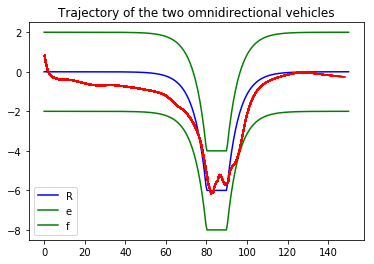

In [61]:
print(len(traj[0]))

draw_agent_traj(traj)
pickle.dump((traj, nn_traj, mpc_traj, train_traj), open('safe_path_bk0.p', 'wb'))

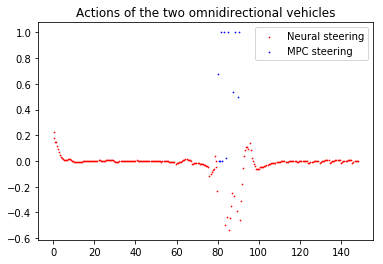

In [62]:
def draw_str(nn_traj, mpc_traj):
    str_nn = []
    posx_nn = []
    str_mpc = []
    posx_mpc = []
    for i in nn_traj[-1]:
        posx_nn.append(i[0][0])
        str_nn.append(i[1][1])
    for j in mpc_traj[-1]:
        posx_mpc.append(j[0][0])
        str_mpc.append(j[1][1])  

    _ = plt.title("Actions of the two omnidirectional vehicles")
    _ = plt.scatter(posx_nn, str_nn, s = 0.5, c = "r")
    _ = plt.scatter(posx_mpc, str_mpc, s = 0.5, c = "b")
    _ = plt.legend(["Neural steering", "MPC steering"])

draw_str(nn_traj, mpc_traj)

Now implement the MPSC guided controller. MPSC solves feasiblity problem to verify the safety of each output of the regression model. Once the output is unsafe, then MPC solves an optimal control and overrides the regression model.

The red curve in the plot is the trajecotry of the hybrid controller. It can be seen that the vehicle still drive out of the lane boundaries even with the existence of the MPSC. It is because horizon being 30 is too short to predict the unsafe outcome and prevent the vehicle from moving out of the boundary.

The red dots are the steering commands output by the regression model while the blue dots are from the MPC.

MPSC Guided Learning
=====================

I have considered two algorithms different from what we have discussed. Instead of filtering the learning-based controller's output during deploying phase, MPC can be used as a filter during training phase. The ultimate goal is that the learning model maintains high performance while avoiding performing unsafe behavior.

The basic set up is that the environment has state space $X$, control space $U$ as well as the known, perhaps nonlinear dynamics $x_{k+1} = f(x_k, u_k)$ where $x_k,u_k$ are current state and action pairs and $x_{k+1}$ is next state. Given a learning based controller $g:X\times \Theta\rightarrow U$ where $\Theta$ is the parameter space, a set of trajectories $\{\tau_i|\tau_i=(x^{(i)}_0, u^{(i)}_0, x^{(i)}_1, u^{(i)}_1, \ldots)\}$ can be obtained by executing $g$. Define the convex set of safe states $\{x|x\in X, UNSAFE(x)\leq 0\}$. Assume that an unsafe controller $g$ is at hand. It can generate at least one trajectory $\tau=(x_0, a_0, x_1, a_1, \ldots x_T, a_T\}$ that reaches an unsafe state.

100
55816
[Epoch 1] avg_loss: 0.345
[Epoch 51] avg_loss: 0.344
Finished Training


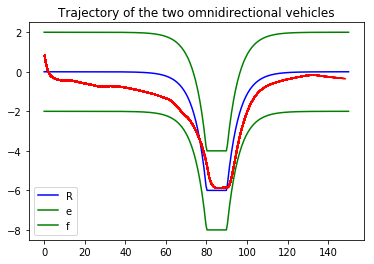

>>>>>Step 0 at [0.19541073796535513, 0.8109158026084073, 9.413916118205409, -0.5539900809472976]
Utilize NN output [[0.46453446 0.21044612]]
>>>>>Step 1 at [ 0.59616671  0.56300469  9.43560475 -0.45637084]
Utilize NN output [[0.5008415  0.17859444]]
>>>>>Step 2 at [ 1.02018317  0.35483938  9.45874369 -0.37299806]
Utilize NN output [[0.52373713 0.15185292]]
>>>>>Step 3 at [ 1.46116015  0.18227792  9.48277265 -0.30172814]
Utilize NN output [[0.3626308  0.15044071]]
>>>>>Step 4 at [ 1.91429405  0.04124871  9.50014911 -0.23093168]
Utilize NN output [[0.37449244 0.11957479]]
>>>>>Step 5 at [ 2.37712727 -0.06757557  9.51804486 -0.17440193]
Utilize NN output [[0.37966254 0.09278946]]
>>>>>Step 6 at [ 2.84625646 -0.15023234  9.53616557 -0.13036952]
Utilize NN output [[0.379892   0.06998964]]
>>>>>Step 7 at [ 3.31946793 -0.21227659  9.55429626 -0.09705226]
Utilize NN output [[0.376549  0.0509719]]
>>>>>Step 8 at [ 3.79538219 -0.25861072  9.57228159 -0.0727233 ]
Utilize NN output [[0.37067187 0.

Utilize NN output [[ 0.11946925 -0.00063024]]
>>>>>Step 85 at [ 4.24837099e+01 -8.46497095e-01  1.04171752e+01 -2.09666969e-02]
Utilize NN output [[ 0.11617636 -0.00051494]]
>>>>>Step 86 at [ 4.30045987e+01 -8.57420014e-01  1.04229581e+01 -2.12349075e-02]
Utilize NN output [[ 0.22233082 -0.00144474]]
>>>>>Step 87 at [ 4.35259025e+01 -8.68491515e-01  1.04338950e+01 -2.19878308e-02]
Utilize NN output [[ 0.21341147 -0.0010833 ]]
>>>>>Step 88 at [ 4.40477338e+01 -8.79967304e-01  1.04444065e+01 -2.25529820e-02]
Utilize NN output [[ 0.20489813 -0.00080456]]
>>>>>Step 89 at [ 4.45700739e+01 -8.91749628e-01  1.04545104e+01 -2.29731386e-02]
Utilize NN output [[ 0.19677114 -0.00059886]]
>>>>>Step 90 at [ 4.50929042e+01 -9.03762796e-01  1.04642239e+01 -2.32861793e-02]
Utilize NN output [[ 0.18900552 -0.00045322]]
>>>>>Step 91 at [ 4.56162070e+01 -9.15950721e-01  1.04735632e+01 -2.35233085e-02]
Utilize NN output [[ 0.18158509 -0.00036065]]
>>>>>Step 92 at [ 4.61399647e+01 -9.28273509e-01  1.048254

Utilize NN output [[0.09709454 0.01618752]]
>>>>>Step 167 at [ 8.56775383e+01 -5.88248394e+00  1.08652203e+01  3.50385087e-03]
Utilize NN output [[0.08858643 0.00903244]]
>>>>>Step 168 at [ 8.62209064e+01 -5.88058006e+00  1.08696381e+01  8.41068763e-03]
Utilize NN output [[0.08079299 0.00406747]]
>>>>>Step 169 at [ 8.67644699e+01 -5.87600821e+00  1.08736690e+01  1.06212735e-02]
Utilize NN output [[0.07368377 0.00083168]]
>>>>>Step 170 at [ 8.73082146e+01 -5.87023273e+00  1.08773465e+01  1.10734431e-02]
Utilize NN output [[ 0.06720912 -0.00110833]]
>>>>>Step 171 at [ 8.78521324e+01 -5.86420944e+00  1.08807019e+01  1.04706573e-02]
Utilize NN output [[ 0.06132011 -0.00211791]]
>>>>>Step 172 at [ 8.83962143e+01 -5.85851233e+00  1.08837641e+01  9.31843961e-03]
Utilize NN output [[ 0.05596214 -0.00249652]]
>>>>>Step 173 at [ 8.89404487e+01 -5.85344077e+00  1.08865593e+01  7.95986541e-03]
Utilize NN output [[ 0.05108998 -0.00247465]]
>>>>>Step 174 at [ 8.94848232e+01 -5.84910753e+00  1.088911

Utilize NN output [[ 0.00888761 -0.00599352]]
>>>>>Step 250 at [ 1.30217353e+02 -1.79322951e-01  1.09841735e+01  6.12309205e-03]
Utilize NN output [[ 0.00808662 -0.00480915]]
>>>>>Step 251 at [ 1.30766562e+02 -1.75960054e-01  1.09845779e+01  3.48188626e-03]
Utilize NN output [[ 0.00736023 -0.00365439]]
>>>>>Step 252 at [ 1.31315797e+02 -1.74047674e-01  1.09849459e+01  1.47479908e-03]
Utilize NN output [[ 0.00670159 -0.00259809]]
>>>>>Step 253 at [ 1.31865052e+02 -1.73237632e-01  1.09852809e+01  4.78105069e-05]
Utilize NN output [[ 0.00610395 -0.00167863]]
>>>>>Step 254 at [ 1.32414323e+02 -1.73211371e-01  1.09855861e+01 -8.74199229e-04]
Utilize NN output [[ 0.00556133 -0.00091897]]
>>>>>Step 255 at [ 1.32963609e+02 -1.73691557e-01  1.09858642e+01 -1.37896989e-03]
Utilize NN output [[ 0.00506818 -0.00031988]]
>>>>>Step 256 at [ 1.33512908e+02 -1.74449024e-01  1.09861176e+01 -1.55467957e-03]
Utilize NN output [[ 0.01016992 -0.01434143]]
>>>>>Step 257 at [ 1.34062226e+02 -1.75303038e-01  

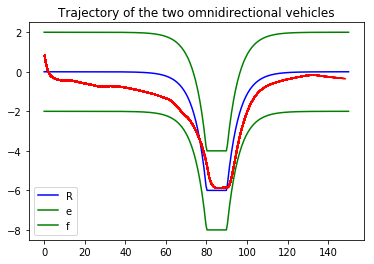

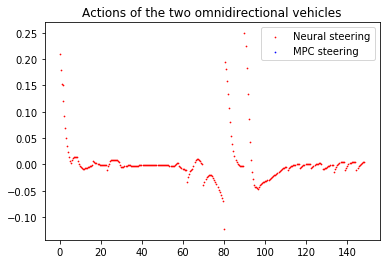

In [63]:
def train_temp(agent, x0s, train_traj = None, paths = None):
    n = 2
    
    #agent = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_H2', batch_size = 1, checkpoint = 'checkpoints/mlp_H2_995.pt')
    
    X = []
    Y = []
    
    if train_traj is not None and train_traj is not []:
        print(len(train_traj))
        for i_traj in range(len(train_traj)):
            for i_xy in range(len(train_traj[i_traj])):
                X.append([x for x in train_traj[i_traj][i_xy][0]])
                Y.append([y for y in train_traj[i_traj][i_xy][1]])
    if train_traj is not None or paths is not None:
        agent.data_process(X = X, Y = Y, paths = paths)
    
    agent.train(num_epoch = 100)
    #for i in range(len(X)):
    #    print(agent_.run([X[i]]), Y[i])

    agent_temp_traj = agent_run(agent, x0s)    
    draw_agent_traj(agent_temp_traj)
    
    # Random initial action path.
    us_init = np.zeros((n - 1, dynamics.action_size))

    J_hist = []
    q1 = [100.0, 10.0]
    q2 = [100.0, 10.0]

    traj_, nn_traj_, mpc_traj_, train_traj_ = MPSC(agent, x0s)
    draw_agent_traj(traj_)
    draw_str(nn_traj_, mpc_traj_)
    return train_traj_

H = 2 
agent_ = NeuralNetwork(input_size = (H + 1) * dynamics.state_size, model_name = 'mlp_temp_H2', batch_size = 500, checkpoint = 'checkpoints/mlp_H2.pt')
paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p']
train_traj_ = train_temp(agent_, x0s, 100 * train_traj, paths)  

181
27959
[Epoch 1] avg_loss: 0.671
[Epoch 6] avg_loss: 0.671
[Epoch 11] avg_loss: 0.671
[Epoch 16] avg_loss: 0.671
[Epoch 21] avg_loss: 0.671
[Epoch 26] avg_loss: 0.671
[Epoch 31] avg_loss: 0.671
[Epoch 36] avg_loss: 0.671
[Epoch 41] avg_loss: 0.670
[Epoch 46] avg_loss: 0.671
[Epoch 51] avg_loss: 0.671
[Epoch 56] avg_loss: 0.671
[Epoch 61] avg_loss: 0.672
[Epoch 66] avg_loss: 0.671
[Epoch 71] avg_loss: 0.671
[Epoch 76] avg_loss: 0.671
[Epoch 81] avg_loss: 0.672
[Epoch 86] avg_loss: 0.671
[Epoch 91] avg_loss: 0.670
[Epoch 96] avg_loss: 0.671
Finished Training


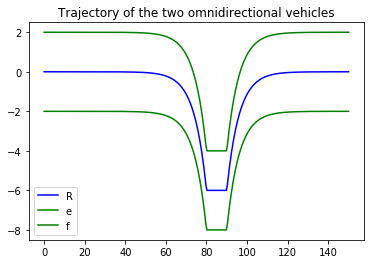

TypeError: 'NoneType' object is not iterable

In [193]:
train_traj_aggr = 100 * train_traj_[:]

#raise TypeError
itr_train = 0
batch_size = 5
x0s = [[x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
                  x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
                  x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
                  x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)] for i in range(5)]
while itr_train < batch_size:
    # Initial state.
    agent_ = NeuralNetwork(input_size = (n + 1) * 4, model_name = 'mlp_temp_H2', batch_size = 500, checkpoint = 'checkpoints/mlp_temp.pt')
    train_traj_aggr = train_traj_aggr + int((batch_size - 1 - itr_train) * 20 + 1) * train_traj_[:]
    train_traj_ = train_temp(agent, x0s[:itr_train], train_traj_aggr, paths) 
    itr_train += 1

Done


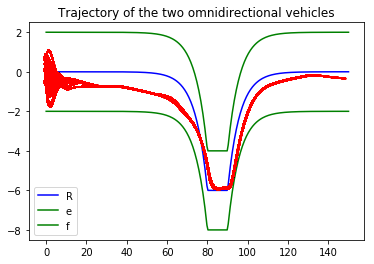

In [66]:
#x0s = []
batch_size = 20
for i_batch in range(batch_size):
    
    x0s.append([x_nominal[0][0] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.5 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.5 * (2 * random.random() - 1.0)])  # Initial state.
    
N = 300
H = 2
agent_traj_ = agent_run(agent_, x0s)
        

print("Done")
draw_agent_traj(agent_traj_)

<h2>MPSC Guided Policy Search</h2>

The algorithm is inspired by the motivation of iLQR, which is to linearize the nonlinear dynamics. Given one trajectory $\tau$, a perturbation can be added to this trajectory, i.e. $x_k\rightarrow x_k + \delta x_k, u_k\rightarrow u_k +\delta u_k$. Then the relationship between $\delta x_k,\delta u_k$ can be obtained as follows.

\begin{eqnarray}
x_{k+1} &=& f(x_k, u_k)\\
x_{k+1} \delta x_{k+1} &=& f(x_k+\delta x_k, u_k + \delta u_k) \\
\delta x_{k+1} &=& f(x_k+\delta, u_k + \delta u_k) - f(x_k, u_k)\\
&\approx& \nabla_x f(x_k, u_k) \delta x_k + \nabla_u f(x_k, u_k) \delta u_k
\end{eqnarray}


Usually, learning-based controller upates its model parameter iteratively during the training phase. We can use MPSC to filter the update. It is already known that $u_k=\pi(x_k; \theta)$.Then the following equation holds.

\begin{eqnarray}
u_k &=& \pi(x_k; \theta)\\
u_k + \delta u_k &=& \pi(x_k + \delta x_k; \theta + \delta \theta)\\
\delta u_k &\approx& \nabla_x \pi(x_k; \theta) \delta x_k + \nabla_\theta \pi(x_k; \theta) \delta \theta
\end{eqnarray}

Then interpolate it into the linearized dynmics. 
$$\delta x_{k+1} \approx [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta$$


At this end, we can determine our MPSC problem as, finding the minimal perturbation on the learning model parameters such that the unsafe trajecotries becomes safe.

Previously, we used L-2 norm of the perturbation on the model parameters, i.e. $||\delta \theta||^2_2$, to estimate the loss $L(\delta\theta)$. The optimization problem is as follows.

\begin{eqnarray}
\underset{\delta\theta}{min}&&||\delta \theta||_2^2 \\
s.t. && \delta x_{k+1} = [\nabla_x f(x_k, u_k)  + \nabla_u f(x_k, u_k) \nabla_x \pi(x_k; \theta) ]\delta x_k + \nabla_u f(x_k, u_k) \nabla_\theta \pi(x_k; \theta) \delta \theta\qquad k=0, 1, 2, \ldots, T\\
&& \delta x_0 = 0\\
&& UNSAFE(x_k+\delta x_k)\leq 0\qquad k=0, 1, 2, \ldots, T
\end{eqnarray}

It is a typical Quadratic Programming problem especially if the constrains are all convex. But it would be extremely computationally expensive for traditional QP solver because the size of $\nabla_\theta \pi(x; \theta)$ can be immensively large. 

Considering the difficulty, we can alternate the problem in the following way.

Firstly, given the current model parameter $\theta_i$, the linearization of the perturbation on the learning model can be rearranged in the following way.

$$\delta \theta_i^T \nabla_\theta \pi(x_k; \theta_i) \approx \delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)$$

Let the optimal control at state $x_k$ be $u^*_k$, which can be presumably obtained with the initial model parametere $\theta_0$, i.e. $u^*_k= \pi(x_k; \theta_0)$. The loss of the model based on this specific data point can be evaluated by using square error  
$$J_{(x_k, u^*_k)}(\theta_i) = ||\pi(x_k; \theta_i) - u^*_k||^2_2$$ 
or log likelihood with fixed covariance $\Sigma$
$$J_{(x_k, u^*_k)}(\theta_i) = -log[\frac{1}{(2\pi)^{\frac{n}{2}}\Sigma} exp\{-\frac{1}{2}[\pi(x_k; \theta_i) - u^*_k]^T \Sigma^{-1}[\pi(x_k,\theta_i)-u^*_k]\}$$

Either way, up to a scale of constant, $\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)= \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]$.

Evaluating the loss of the model based on a set $D=\{\tau = (x_0, u^*_0, \ldots, x_k, u^*_k, \ldots)\}$ of trajectories sampled from the roll-out of the unchanged model, then the increase on the model's loss due to the perturbation is $J_{D}(\theta_i+\delta\theta_i) - J_{D}(\theta_i)\approx \delta\theta_i^T \nabla_\theta J_{D}(\theta_i) + \frac{1}{2}\delta\theta_i^T \nabla^2_\theta J_{D}(\theta_i)\delta\theta_i$ and it is to be minimized.

Using Fisher Information Matrix to replace the second order derivative, the increase of loss turns out to be
\begin{eqnarray}
&&\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\delta\theta_i^T \mathbb{E}_{(x_k, u^*_k)\sim D}[\nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T]\delta\theta_i\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} [\delta\theta_i^T\nabla_\theta J_{(x_k, u^*_k)}(\theta_i)] + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}[\delta\theta_i^T \nabla_\theta J_{(x_k, u^*_k)}(\theta_i) \nabla_\theta  J_{(x_k, u^*_k)}(\theta_i)^T\delta\theta_i]\\
&=&\mathbb{E}_{(x_k, u^*_k)\sim D} \{\delta\theta_i^T\nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k]\} + \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{\delta\theta_i^T \nabla_\theta \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T\nabla_\theta \pi(x_k; \theta_i)^T\delta\theta_i\}\\
&\approx& \mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k]\}+ \frac{1}{2}\mathbb{E}_{(x_k, u^*_k)\sim D}\{[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)][\pi(x_k; \theta_i) - u^*_k] [\pi(x_k; \theta_i) - u^*_k]^T[\delta u_k^T -\delta x_k^T \nabla_x \pi(x_k; \theta_i)]^T\}\\
&\approx& \frac{1}{4|D|} \sum_{(x_k, u^*_k)\in D} \\
&&\begin{bmatrix} 1\\\delta x_k \\ \delta u_k\end{bmatrix}^T 
\begin{bmatrix} 
0 &-2[\pi(x_k; \theta_i) - u^*_k]^T\nabla_x \pi(x_k; \theta_i)^T &  2[\pi(x_k; \theta_i) - u^*_k]^T\\ 
-2\nabla_x \pi(x_k; \theta_i)[\pi(x_k; \theta_i) - u^*_k] & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & \nabla_x \pi(x_k; \theta_i) [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \\
2[\pi(x_k; \theta_i) - u^*_k] & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T \nabla_x \pi(x_k; \theta_i)^T & [\pi(x_k; \theta_i) - u^*_k][\pi(x_k; \theta_i) - u^*_k]^T 
\end{bmatrix} 
\begin{bmatrix}1\\\delta x_k \\ \delta u_k\end{bmatrix} 
\end{eqnarray}

As a result, we get a quadratic objective function of which the variables are only $\delta x$ and $\delta u$. As $\pi(,)$ is considered, variable $\delta\theta$ is implicit in this objective function. After solving the $\delta x$ and $\delta u$, $\delta\theta$ can be directly derived and used to modify $\theta_i$. One thing to be stressed is that $\pi(x_k;\theta_i + \delta\theta_i)\neq u_k + \delta u_k$ because $\delta u_k$ is induced by both $\delta x_k$ and $\delta \theta_i$.

If we choose to directly constrain the trajectory, the $UNSAFE()$ function can be rewritten as a barrier function $b:X\rightarrow \mathbb{R}^+$ such that $UNSAFE(x)\leq \Rightarrow b(x)\approx 0$ and $UNSAFE(x)\geq 0 \Rightarrow b(x)\approx \infty$. One candidate is the exponential. Linearize $b$ in the same way as LQR.
\begin{eqnarray}
b(x_k + \delta x_k) = b(x_k) + \delta x_k^T \nabla_x b(x_k) + \delta x_k^T \nabla_x b(x_k) \delta x_k
\end{eqnarray}

For instance, $b(x) = w_1 exp[w_2*UNSAFE(x)]$, the barrier can be written as follows. It can be added to the objective. 
$$b(x_k+\delta x_k) = b(x_k) + \delta x_k^T w_1w_2 exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) ^T + \delta x_k^T \{w_1 w_2exp[w_2 UNSAFE(x)]\nabla_{x,x} UNSAFE(x)  + w_1 w_2^2  exp[w_2 UNSAFE(x)]\nabla_x UNSAFE(x) \nabla_x UNSAFE(x)^T\}\delta_x$$

Actually, this constraint will not be needed to be directly enforced in the optimization if the following procedure works.

Firstly we need an initially feasible solution $\delta {\bf x}$ and $\delta {\bf u}$ to ensure the safety of ${\bf x} + \delta{\bf x}$. In fact they can be directly obtained by using MPSC. Once MPSC overrides the learning based controller and invokes a $\delta u_k=u_k^{safe} - u_k$, a safe trajectory ${\bf x} + \delta{\bf x}$ can be obtained in the end. To get $\delta {\bf x}$, the original unsafe trajectory ${\bf x}$ can be simulated at the very first time when MPSC is involved. From the feasible solution, the first feasible $\delta \theta_1$ can be obtained. Henceforth, an iLQR style backward and forward pass can be implemented. 

It is known that the optimal $\delta {\bf u}$ is affine in $\delta {\bf x}$, i.e. $\delta {\bf u} = k + K \delta {\bf x}$. Likewise, $\delta\theta^T \nabla_\theta \pi(x;\theta) = k^T + \delta {\bf x}^T [K^T + \nabla_x \pi(x; \theta)]$ in which $k, K$ should be updated via backward pass while $\delta \theta$ is updated at the end of the forward pass.  

During the forward pass, MPSC should keep monitoring and intervene when necessary. Therefore, the resulted trajectory after a forward pass may not be exctly be induced from the optimal solution. The iteration goes on with safety guarantee and terminates when the changes on $\delta \theta$ and $\delta {\bf x}$ are trivia.

**Initialization**

1. Learning based controller $\pi(;\theta_0)$
2. MPSC verifier

**Iteration** $i$

1. Run $\pi(;\theta_i)$ and the safe controller to generate a safe trajectory $\tau_i$. Train the learning model using $\tau_i$ with an online scheme to obtain $\hat{\theta_i}$ such that all $u$'s in the trajectory equals the outputs of $\pi(;\hat{\theta_i})$ despite some of them are originally generated by the MPSC.
2. Run $\pi(;\theta_0)$ at every state in the trajectory to obtain $u^*$'s.
3. Solve the QP to find $\delta x$'s and $\delta u$'s that should be applied to this trajectory. 
4. Solve $\delta \theta_i$ and add to $\theta_i$ to obtain $\theta_{i+1}$.



In [67]:
import torch.utils.data as data_utils
import torch.nn as nn
import torch.nn.functional as F
import torch

from torch.autograd import Variable
from scipy.linalg import block_diag

from scipy.sparse import coo_matrix, vstack, linalg
from cvxopt import spmatrix, spdiag, matrix, solvers, sparse

n = 2
checkpoint_0 = 'checkpoints/mlp_H2.pt'
paths = ['expert_traj/expert_pts_10058_H10.p', 'expert_traj/expert_pts_17358_H10.p']
epoch_init = 0
num_epoch = 10
use_cuda = torch.cuda.is_available()
device = torch.device("cuda" if use_cuda else "cpu")

def numpy_sparse_to_spmatrix(X):
    X = coo_matrix(X)
    coo = X.tocoo()
    SP = spmatrix(coo.data.tolist(), coo.row.tolist(), coo.col.tolist(), size = coo.shape)
    return SP

In [68]:
agent_0 = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC_0', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)

agent_0.data_process(paths = paths)

if checkpoint_0 is not None:
    checkpoint = torch.load(checkpoint_0, map_location=device)
    agent_0.model.load_state_dict(checkpoint['model_state_dict'])
    agent_0.optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    epoch_init = checkpoint['epoch'] + 1
    loss = checkpoint['loss']
    agent_0.model.eval()
    loss.backward()
    agent_0.optimizer.step()

27416


100
55816
[Epoch 1] avg_loss: 0.345
[Epoch 51] avg_loss: 0.344
Finished Training


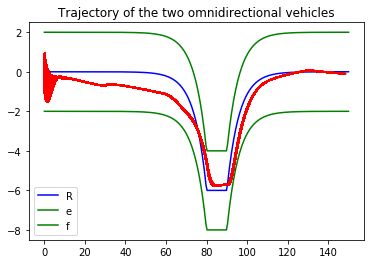

>>>>>Step 0 at [0.003962498773724699, -0.41136648071353665, 10.095247747437455, -0.5194514917236153]
Utilize NN output [[0.1456951 0.4522291]]
>>>>>Step 1 at [ 0.44229947 -0.66202235 10.10248139 -0.30556872]
Utilize NN output [[0.08663547 0.32265943]]
>>>>>Step 2 at [ 0.9241272  -0.81401415 10.10680236 -0.14801567]
Utilize NN output [[0.09250592 0.25121218]]
>>>>>Step 3 at [ 1.4240558  -0.88855658 10.11141451 -0.0236728 ]
Utilize NN output [[0.0945295 0.1827529]]
>>>>>Step 4 at [ 1.92960265 -0.90052653 10.11612695  0.06770667]
Utilize NN output [[0.09389046 0.121193  ]]
>>>>>Step 5 at [ 2.43436684 -0.86629831 10.12080773  0.12870849]
Utilize NN output [[0.09168994 0.06933209]]
>>>>>Step 6 at [ 2.93633485 -0.80133162 10.12537942  0.16373721]
Utilize NN output [[0.08840664 0.0260067 ]]
>>>>>Step 7 at [ 3.43594122 -0.71878849 10.12978828  0.17690063]
Utilize NN output [[ 0.08442961 -0.00834642]]
>>>>>Step 8 at [ 3.93462992 -0.62963825 10.13399975  0.17267336]
Utilize NN output [[ 0.080120

Utilize NN output [[ 0.11099761 -0.0117054 ]]
>>>>>Step 120 at [62.18192675 -1.25589281 10.74254633 -0.08012238]
Utilize NN output [[ 0.10224241 -0.00938016]]
>>>>>Step 121 at [62.71745787 -1.29889289 10.74764071 -0.08516057]
Utilize NN output [[ 0.09452695 -0.00779082]]
>>>>>Step 122 at [63.25300983 -1.34461138 10.75235303 -0.08934714]
Utilize NN output [[ 0.08748364 -0.0068766 ]]
>>>>>Step 123 at [63.78859167 -1.39259182 10.75671609 -0.09304406]
Utilize NN output [[ 0.0810338  -0.00651309]]
>>>>>Step 124 at [64.32420172 -1.44257147 10.76075893 -0.09654698]
Utilize NN output [[ 0.07511264 -0.00659206]]
>>>>>Step 125 at [64.85982728 -1.49444578 10.76450752 -0.10009371]
Utilize NN output [[ 0.06966706 -0.00701666]]
>>>>>Step 126 at [65.39544524 -1.54823753 10.76798525 -0.10387019]
Utilize NN output [[ 0.06471544 -0.00129804]]
>>>>>Step 127 at [65.93102306 -1.60406904 10.77121651 -0.10456906]
Utilize NN output [[0.06026205 0.00435072]]
>>>>>Step 128 at [66.46671689 -1.66029111 10.7742259

Utilize NN output [[ 0.00805816 -0.00513984]]
>>>>>Step 245 at [1.28796517e+02 4.62152851e-02 1.09948882e+01 8.58016275e-03]
Utilize NN output [[ 0.00732894 -0.00426022]]
>>>>>Step 246 at [1.29346250e+02 5.09322023e-02 1.09952547e+01 6.23814677e-03]
Utilize NN output [[ 0.00666802 -0.00336091]]
>>>>>Step 247 at [1.29896011e+02 5.43617327e-02 1.09955881e+01 4.39044817e-03]
Utilize NN output [[ 0.00606833 -0.00250315]]
>>>>>Step 248 at [1.30445792e+02 5.67755362e-02 1.09958915e+01 3.01426988e-03]
Utilize NN output [[ 0.00552432 -0.00173312]]
>>>>>Step 249 at [1.30995591e+02 5.84327838e-02 1.09961677e+01 2.06140948e-03]
Utilize NN output [[ 0.00503009 -0.00107557]]
>>>>>Step 250 at [1.31545405e+02 5.95661761e-02 1.09964192e+01 1.47005486e-03]
Utilize NN output [[ 0.01010691 -0.01506095]]
>>>>>Step 251 at [ 1.32095238e+02  6.03744614e-02  1.09969245e+01 -6.81014767e-03]
Utilize NN output [[ 0.00916724 -0.00954343]]
>>>>>Step 252 at [ 1.32645083e+02  5.66298783e-02  1.09973829e+01 -1.205740

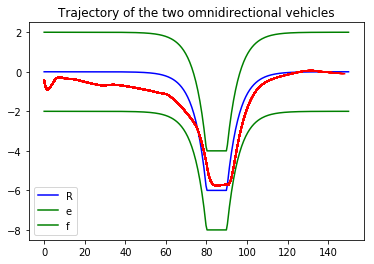

Done


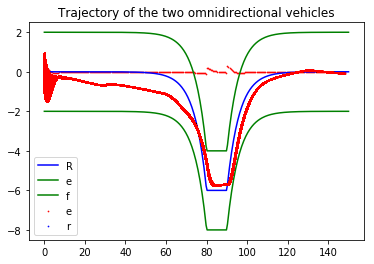

In [69]:
x0s = []
batch_size = 30
for i_batch in range(batch_size):
    x0s.append([x_nominal[0][0] + 0.1 * (2 * random.random() - 1.0), \
          x_nominal[0][1] + 1.0 * (2 * random.random() - 1.0), \
          x_nominal[0][2] + 0.1 * (2 * random.random() - 1.0), \
          x_nominal[0][3] + 0.1 * (2 * random.random() - 1.0)])  # Initial state.

agent = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)
'''
# Run MPSC guided controller and generate safe trajectory
traj, nn_traj, mpc_traj, train_traj = MPSC(agent, x0s)
draw_agent_traj(traj)
draw_str(nn_traj, mpc_traj)
'''

# Collect training trajectory
train_traj_aggr = [i for i in train_traj[:]] * 100
itr = 0

while itr < 1:
    train_traj = train_temp(agent, x0s, train_traj_aggr, paths)
    train_traj_aggr = train_traj_aggr + [i for i in train_traj[:]] * 100
    itr += 1

agent_traj = agent_run(agent, x0s) 
print("Done")
draw_agent_traj(agent_traj)
 

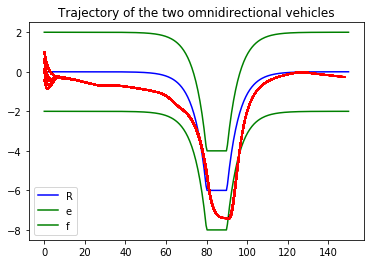

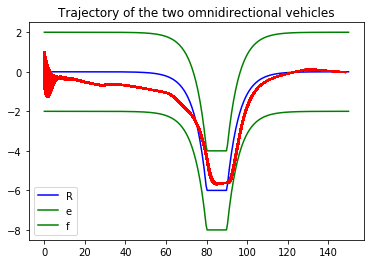

Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished it

Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Fin

Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished i

Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished itera

Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 22
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished i

Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 3

 1:  3.7093e-02 -7.6920e+00  2e+01  7e-01  6e+04
 2:  7.0026e-03 -3.8322e-01  8e-01  3e-02  3e+03
 3:  1.4964e-03 -2.2016e-02  4e-02  2e-03  2e+02
 4:  2.6161e-04 -1.4413e-03  3e-03  1e-04  9e+00
 5:  5.7526e-05 -2.2670e-04  5e-04  1e-05  1e+00
 6:  1.1357e-05 -2.8472e-05  6e-05  1e-06  1e-01
 7:  2.4449e-06 -4.0775e-06  8e-06  1e-07  1e-02
 8:  5.1481e-07 -6.6458e-07  1e-06  1e-08  1e-03
 9:  1.5633e-07 -2.1486e-07  4e-07  3e-09  3e-04
10:  2.6718e-08 -2.7098e-08  5e-08  3e-11  3e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  4.4361e-02 -7.4459e+00  2e+01  6e-01  6e+04
 2:  8.4503e-03 -5.2129e-01  1e+00  4e-02  4e+03
 3:  1.4452e-03 -2.4092e-02  5e-02  2e-03  2e+02
 4:  3.0440e-04 -1.9159e-03  4e-03  1e-04  1e+01
 5:  6.2267e-05 -2.4151e-04  5e-04  1e-05  1e+00
 6:  1.1832e-05 -2.7833e-05  5e-05  1e-06  1e-01
 7:  2.5510e-06 -4.2196e-06  8e-06  1e-07  1e-02
 8:  5.5533e-07 -7.2630e-0

 1:  2.7939e-02 -8.4051e+00  2e+01  7e-01  6e+04
 2:  5.7176e-03 -3.7886e-01  8e-01  3e-02  3e+03
 3:  1.1153e-03 -1.8109e-02  4e-02  1e-03  1e+02
 4:  2.1585e-04 -1.1750e-03  2e-03  8e-05  7e+00
 5:  4.4326e-05 -1.5981e-04  3e-04  1e-05  8e-01
 6:  8.7661e-06 -1.8551e-05  4e-05  8e-07  7e-02
 7:  1.8279e-06 -2.8170e-06  6e-06  8e-08  7e-03
 8:  4.3963e-07 -5.7579e-07  1e-06  1e-08  1e-03
 9:  1.1680e-07 -1.5068e-07  3e-07  2e-09  2e-04
10:  1.9377e-08 -1.9603e-08  4e-08  2e-11  2e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.3526e-02 -9.1770e+00  2e+01  8e-01  7e+04
 2:  4.2710e-03 -3.4537e-01  7e-01  3e-02  2e+03
 3:  9.0024e-04 -1.6483e-02  3e-02  1e-03  1e+02
 4:  1.9047e-04 -1.1170e-03  2e-03  8e-05  7e+00
 5:  3.7591e-05 -1.3578e-04  3e-04  8e-06  7e-01
 6:  7.3381e-06 -1.4775e-05  3e-05  6e-07  5e-02
 7:  1.5274e-06 -2.2872e-06  5e-06  6e-08  5e-03
 8:  3.7955e-07 -4.9299e-0

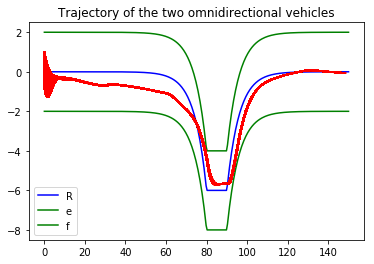

>>>>>>>>>>>>>>>>>>>>
Finished epoch 0
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Fi

Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solu

Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished i

Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished itera

Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 22
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished i

Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37

 1:  3.8080e-02 -7.7069e+00  2e+01  7e-01  6e+04
 2:  7.1925e-03 -3.9494e-01  8e-01  3e-02  3e+03
 3:  1.5255e-03 -2.2444e-02  4e-02  2e-03  2e+02
 4:  2.6532e-04 -1.4784e-03  3e-03  1e-04  9e+00
 5:  5.8298e-05 -2.2917e-04  5e-04  1e-05  1e+00
 6:  1.1419e-05 -2.8383e-05  6e-05  1e-06  1e-01
 7:  2.4902e-06 -4.1959e-06  8e-06  1e-07  1e-02
 8:  5.1976e-07 -6.7017e-07  1e-06  1e-08  1e-03
 9:  1.5855e-07 -2.1828e-07  4e-07  3e-09  3e-04
10:  2.7122e-08 -2.7508e-08  6e-08  3e-11  3e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  4.4227e-02 -7.4501e+00  2e+01  6e-01  6e+04
 2:  8.5088e-03 -5.2191e-01  1e+00  4e-02  4e+03
 3:  1.4560e-03 -2.4560e-02  5e-02  2e-03  2e+02
 4:  3.0726e-04 -1.9555e-03  4e-03  1e-04  1e+01
 5:  6.2789e-05 -2.4473e-04  5e-04  2e-05  1e+00
 6:  1.1918e-05 -2.8256e-05  6e-05  1e-06  1e-01
 7:  2.5727e-06 -4.2712e-06  9e-06  1e-07  1e-02
 8:  5.5615e-07 -7.2613e-0

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.8397e-02 -8.4606e+00  2e+01  7e-01  6e+04
 2:  5.7376e-03 -3.7024e-01  7e-01  3e-02  3e+03
 3:  1.1083e-03 -1.7795e-02  4e-02  1e-03  1e+02
 4:  2.1562e-04 -1.1631e-03  2e-03  8e-05  7e+00
 5:  4.4261e-05 -1.5813e-04  3e-04  9e-06  8e-01
 6:  8.7311e-06 -1.8242e-05  4e-05  7e-07  6e-02
 7:  1.8100e-06 -2.7579e-06  6e-06  7e-08  6e-03
 8:  4.3916e-07 -5.7243e-07  1e-06  1e-08  1e-03
 9:  1.1804e-07 -1.5206e-07  3e-07  2e-09  2e-04
10:  1.9568e-08 -1.9795e-08  4e-08  2e-11  2e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.3689e-02 -8.8726e+00  2e+01  8e-01  7e+04
 2:  4.1062e-03 -3.3286e-01  7e-01  3e-02  2e+03
 3:  8.8445e-04 -1.5622e-02  3e-02  1e-03  1e+02
 4:  1.8432e-04 -1.0213e-03  2e-03  7e-05  6e+00
 5:  3.6270e-05 -1.2692e-04  3e-04  8e-06  7e-01
 6:  7.1299e-06 -1.4030e-05

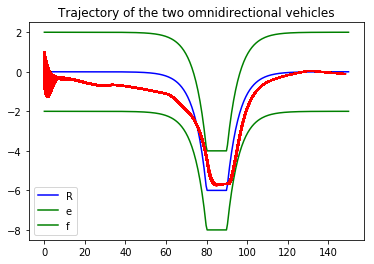

>>>>>>>>>>>>>>>>>>>>
Finished epoch 1
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Fi

Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solu

Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished i

Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished itera

Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 22
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished i

Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37

 1:  3.7908e-02 -7.7819e+00  2e+01  7e-01  6e+04
 2:  7.2139e-03 -3.9528e-01  8e-01  3e-02  3e+03
 3:  1.5272e-03 -2.2623e-02  5e-02  2e-03  2e+02
 4:  2.6667e-04 -1.4890e-03  3e-03  1e-04  9e+00
 5:  5.8521e-05 -2.2994e-04  5e-04  1e-05  1e+00
 6:  1.1461e-05 -2.8562e-05  6e-05  1e-06  1e-01
 7:  2.4994e-06 -4.2170e-06  8e-06  1e-07  1e-02
 8:  5.2048e-07 -6.7034e-07  1e-06  1e-08  1e-03
 9:  1.5993e-07 -2.2059e-07  4e-07  3e-09  3e-04
10:  2.7381e-08 -2.7773e-08  6e-08  3e-11  3e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  4.6961e-02 -7.1175e+00  1e+01  6e-01  5e+04
 2:  8.2190e-03 -5.1750e-01  1e+00  4e-02  4e+03
 3:  1.4353e-03 -2.2751e-02  5e-02  2e-03  2e+02
 4:  3.0158e-04 -1.8066e-03  4e-03  1e-04  1e+01
 5:  6.1792e-05 -2.3324e-04  5e-04  1e-05  1e+00
 6:  1.1796e-05 -2.6950e-05  5e-05  1e-06  1e-01
 7:  2.5071e-06 -4.0452e-06  8e-06  1e-07  1e-02
 8:  5.6424e-07 -7.4041e-0

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.8645e-02 -8.5248e+00  2e+01  7e-01  6e+04
 2:  5.7623e-03 -3.7104e-01  7e-01  3e-02  3e+03
 3:  1.1142e-03 -1.7818e-02  4e-02  1e-03  1e+02
 4:  2.1658e-04 -1.1635e-03  2e-03  8e-05  7e+00
 5:  4.4448e-05 -1.5861e-04  3e-04  9e-06  8e-01
 6:  8.7953e-06 -1.8450e-05  4e-05  8e-07  7e-02
 7:  1.8249e-06 -2.7879e-06  6e-06  8e-08  7e-03
 8:  4.4159e-07 -5.7618e-07  1e-06  1e-08  1e-03
 9:  1.1853e-07 -1.5281e-07  3e-07  2e-09  2e-04
10:  1.9655e-08 -1.9884e-08  4e-08  2e-11  2e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.3253e-02 -8.9407e+00  2e+01  8e-01  7e+04
 2:  4.0435e-03 -3.3555e-01  7e-01  3e-02  2e+03
 3:  8.8562e-04 -1.5744e-02  3e-02  1e-03  1e+02
 4:  1.8442e-04 -1.0249e-03  2e-03  7e-05  6e+00
 5:  3.6396e-05 -1.2853e-04  3e-04  8e-06  7e-01
 6:  7.1574e-06 -1.4270e-05

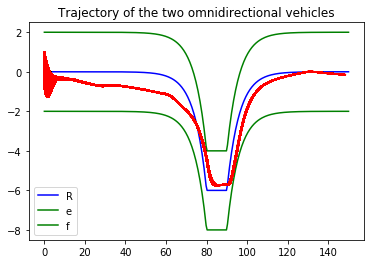

>>>>>>>>>>>>>>>>>>>>
Finished epoch 2
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Fi

Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solu

Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished i

Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished itera

Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 22
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished i

Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37

 1:  3.7818e-02 -7.8275e+00  2e+01  7e-01  6e+04
 2:  7.2895e-03 -3.9256e-01  8e-01  3e-02  3e+03
 3:  1.5333e-03 -2.2249e-02  4e-02  2e-03  2e+02
 4:  2.6642e-04 -1.4757e-03  3e-03  1e-04  9e+00
 5:  5.8763e-05 -2.3156e-04  5e-04  1e-05  1e+00
 6:  1.1558e-05 -2.8668e-05  6e-05  1e-06  1e-01
 7:  2.5146e-06 -4.2382e-06  8e-06  1e-07  1e-02
 8:  5.2709e-07 -6.8077e-07  1e-06  1e-08  1e-03
 9:  1.6195e-07 -2.2382e-07  5e-07  3e-09  3e-04
10:  2.7735e-08 -2.8139e-08  6e-08  3e-11  3e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  4.6804e-02 -7.1361e+00  1e+01  6e-01  5e+04
 2:  8.4486e-03 -5.4040e-01  1e+00  4e-02  4e+03
 3:  1.4801e-03 -2.5029e-02  5e-02  2e-03  2e+02
 4:  3.1333e-04 -2.0281e-03  4e-03  1e-04  1e+01
 5:  6.3805e-05 -2.4883e-04  5e-04  2e-05  1e+00
 6:  1.2030e-05 -2.8095e-05  6e-05  1e-06  1e-01
 7:  2.5649e-06 -4.1847e-06  8e-06  1e-07  1e-02
 8:  5.6669e-07 -7.4143e-0

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.9335e-02 -8.3075e+00  2e+01  7e-01  6e+04
 2:  5.7838e-03 -3.6941e-01  7e-01  3e-02  3e+03
 3:  1.1197e-03 -1.7692e-02  4e-02  1e-03  1e+02
 4:  2.1737e-04 -1.1648e-03  2e-03  8e-05  7e+00
 5:  4.4797e-05 -1.6071e-04  3e-04  1e-05  8e-01
 6:  8.8585e-06 -1.8522e-05  4e-05  8e-07  7e-02
 7:  1.8240e-06 -2.7680e-06  6e-06  7e-08  6e-03
 8:  4.4297e-07 -5.7533e-07  1e-06  1e-08  1e-03
 9:  1.2070e-07 -1.5559e-07  3e-07  3e-09  2e-04
10:  2.0007e-08 -2.0242e-08  4e-08  3e-11  2e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.3468e-02 -8.7288e+00  2e+01  8e-01  7e+04
 2:  4.0302e-03 -3.2971e-01  7e-01  3e-02  2e+03
 3:  8.8543e-04 -1.5483e-02  3e-02  1e-03  1e+02
 4:  1.8352e-04 -9.9857e-04  2e-03  7e-05  6e+00
 5:  3.6225e-05 -1.2647e-04  3e-04  8e-06  7e-01
 6:  7.1249e-06 -1.4084e-05

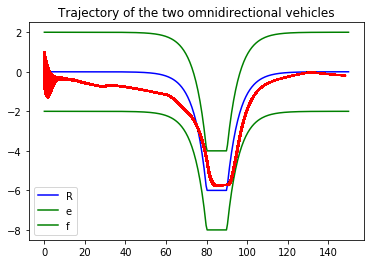

>>>>>>>>>>>>>>>>>>>>
Finished epoch 3
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Fi

Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solu

Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished i

Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished itera

Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 22
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished i

Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37

 1:  3.6850e-02 -7.9783e+00  2e+01  7e-01  6e+04
 2:  7.3526e-03 -4.1084e-01  8e-01  3e-02  3e+03
 3:  1.5528e-03 -2.2744e-02  5e-02  2e-03  2e+02
 4:  2.6871e-04 -1.5274e-03  3e-03  1e-04  9e+00
 5:  5.9217e-05 -2.3479e-04  5e-04  1e-05  1e+00
 6:  1.1612e-05 -2.9192e-05  6e-05  1e-06  1e-01
 7:  2.5346e-06 -4.3021e-06  9e-06  1e-07  1e-02
 8:  5.2533e-07 -6.7579e-07  1e-06  1e-08  1e-03
 9:  1.6184e-07 -2.2375e-07  5e-07  3e-09  3e-04
10:  2.7744e-08 -2.8142e-08  6e-08  3e-11  3e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  4.7615e-02 -7.1640e+00  1e+01  6e-01  5e+04
 2:  8.6307e-03 -5.6211e-01  1e+00  5e-02  4e+03
 3:  1.5188e-03 -2.8598e-02  6e-02  2e-03  2e+02
 4:  3.2816e-04 -2.3474e-03  5e-03  2e-04  1e+01
 5:  6.6420e-05 -2.7050e-04  5e-04  2e-05  1e+00
 6:  1.2277e-05 -2.9227e-05  6e-05  1e-06  1e-01
 7:  2.6092e-06 -4.2721e-06  9e-06  1e-07  1e-02
 8:  5.6893e-07 -7.4045e-0

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.9672e-02 -8.2977e+00  2e+01  7e-01  6e+04
 2:  5.8052e-03 -3.6697e-01  7e-01  3e-02  3e+03
 3:  1.1212e-03 -1.7721e-02  4e-02  1e-03  1e+02
 4:  2.1842e-04 -1.1651e-03  2e-03  8e-05  7e+00
 5:  4.5042e-05 -1.6126e-04  3e-04  1e-05  8e-01
 6:  8.9042e-06 -1.8644e-05  4e-05  8e-07  7e-02
 7:  1.8336e-06 -2.7838e-06  6e-06  7e-08  6e-03
 8:  4.4484e-07 -5.7764e-07  1e-06  1e-08  1e-03
 9:  1.2160e-07 -1.5688e-07  3e-07  3e-09  2e-04
10:  2.0160e-08 -2.0398e-08  4e-08  3e-11  2e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.4002e-02 -8.8230e+00  2e+01  8e-01  7e+04
 2:  4.1086e-03 -3.4373e-01  7e-01  3e-02  3e+03
 3:  9.0825e-04 -1.6302e-02  3e-02  1e-03  1e+02
 4:  1.8713e-04 -1.0341e-03  2e-03  7e-05  6e+00
 5:  3.7161e-05 -1.3201e-04  3e-04  8e-06  7e-01
 6:  7.3304e-06 -1.4816e-05

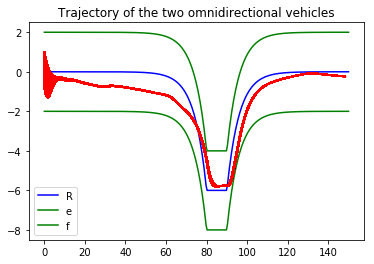

>>>>>>>>>>>>>>>>>>>>
Finished epoch 4
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Fi

Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solu

Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished i

Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished itera

Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 22
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished i

Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37

 1:  3.7665e-02 -8.0151e+00  2e+01  7e-01  6e+04
 2:  7.3857e-03 -4.0513e-01  8e-01  3e-02  3e+03
 3:  1.5620e-03 -2.2352e-02  4e-02  2e-03  2e+02
 4:  2.7023e-04 -1.5131e-03  3e-03  1e-04  9e+00
 5:  5.9732e-05 -2.3561e-04  5e-04  1e-05  1e+00
 6:  1.1760e-05 -2.9487e-05  6e-05  1e-06  1e-01
 7:  2.5653e-06 -4.3569e-06  9e-06  1e-07  1e-02
 8:  5.3365e-07 -6.8801e-07  1e-06  1e-08  1e-03
 9:  1.6515e-07 -2.2912e-07  5e-07  3e-09  3e-04
10:  2.8342e-08 -2.8757e-08  6e-08  3e-11  3e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  4.7860e-02 -7.1906e+00  1e+01  6e-01  5e+04
 2:  8.7420e-03 -5.6831e-01  1e+00  5e-02  4e+03
 3:  1.5316e-03 -2.8378e-02  6e-02  2e-03  2e+02
 4:  3.2931e-04 -2.3288e-03  5e-03  2e-04  1e+01
 5:  6.6729e-05 -2.7088e-04  5e-04  2e-05  1e+00
 6:  1.2262e-05 -2.8553e-05  6e-05  1e-06  1e-01
 7:  2.5944e-06 -4.1970e-06  8e-06  1e-07  1e-02
 8:  5.7355e-07 -7.4632e-0

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  3.0413e-02 -8.3435e+00  2e+01  7e-01  6e+04
 2:  5.8441e-03 -3.6951e-01  7e-01  3e-02  3e+03
 3:  1.1270e-03 -1.7853e-02  4e-02  1e-03  1e+02
 4:  2.1954e-04 -1.1766e-03  2e-03  8e-05  7e+00
 5:  4.5324e-05 -1.6314e-04  3e-04  1e-05  8e-01
 6:  8.9548e-06 -1.8799e-05  4e-05  8e-07  7e-02
 7:  1.8426e-06 -2.8006e-06  6e-06  7e-08  6e-03
 8:  4.4623e-07 -5.7937e-07  1e-06  1e-08  1e-03
 9:  1.2215e-07 -1.5763e-07  3e-07  3e-09  2e-04
10:  2.0253e-08 -2.0493e-08  4e-08  3e-11  2e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.4023e-02 -8.4045e+00  2e+01  7e-01  6e+04
 2:  4.2627e-03 -3.4490e-01  7e-01  3e-02  3e+03
 3:  9.2447e-04 -1.7253e-02  3e-02  1e-03  1e+02
 4:  1.9239e-04 -1.1150e-03  2e-03  8e-05  7e+00
 5:  3.8253e-05 -1.3882e-04  3e-04  8e-06  7e-01
 6:  7.5136e-06 -1.5467e-05

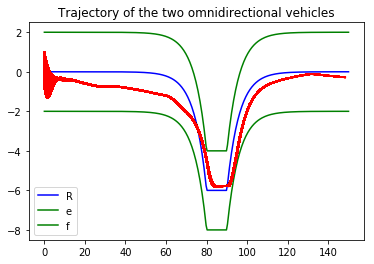

>>>>>>>>>>>>>>>>>>>>
Finished epoch 5
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Fi

Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solu

Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished i

Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished itera

Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 22
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished i

Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37

 1:  3.7740e-02 -8.1884e+00  2e+01  7e-01  6e+04
 2:  7.4502e-03 -4.0708e-01  8e-01  3e-02  3e+03
 3:  1.5652e-03 -2.2491e-02  4e-02  2e-03  2e+02
 4:  2.7004e-04 -1.5184e-03  3e-03  1e-04  9e+00
 5:  5.9891e-05 -2.3870e-04  5e-04  1e-05  1e+00
 6:  1.1803e-05 -2.9721e-05  6e-05  1e-06  1e-01
 7:  2.5556e-06 -4.3181e-06  9e-06  1e-07  1e-02
 8:  5.3419e-07 -6.8908e-07  1e-06  1e-08  1e-03
 9:  1.6469e-07 -2.2793e-07  5e-07  3e-09  3e-04
10:  2.8227e-08 -2.8639e-08  6e-08  3e-11  3e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  4.8255e-02 -7.1568e+00  1e+01  6e-01  5e+04
 2:  8.8817e-03 -5.6304e-01  1e+00  5e-02  4e+03
 3:  1.5225e-03 -2.8351e-02  6e-02  2e-03  2e+02
 4:  3.3035e-04 -2.3060e-03  5e-03  2e-04  1e+01
 5:  6.7131e-05 -2.7412e-04  5e-04  2e-05  1e+00
 6:  1.2307e-05 -2.8670e-05  6e-05  1e-06  1e-01
 7:  2.5862e-06 -4.1488e-06  8e-06  1e-07  1e-02
 8:  5.7404e-07 -7.4525e-0

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  3.0603e-02 -8.3478e+00  2e+01  7e-01  6e+04
 2:  5.8557e-03 -3.7079e-01  7e-01  3e-02  3e+03
 3:  1.1306e-03 -1.8620e-02  4e-02  1e-03  1e+02
 4:  2.2283e-04 -1.1954e-03  2e-03  8e-05  7e+00
 5:  4.5713e-05 -1.6529e-04  3e-04  1e-05  9e-01
 6:  8.9976e-06 -1.8798e-05  4e-05  8e-07  7e-02
 7:  1.8605e-06 -2.8378e-06  6e-06  8e-08  7e-03
 8:  4.5146e-07 -5.8757e-07  1e-06  1e-08  1e-03
 9:  1.2358e-07 -1.5984e-07  3e-07  3e-09  2e-04
10:  2.0505e-08 -2.0751e-08  4e-08  3e-11  2e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.3746e-02 -8.4175e+00  2e+01  7e-01  6e+04
 2:  4.2881e-03 -3.3810e-01  7e-01  3e-02  2e+03
 3:  9.2604e-04 -1.6998e-02  3e-02  1e-03  1e+02
 4:  1.9219e-04 -1.0978e-03  2e-03  8e-05  7e+00
 5:  3.8084e-05 -1.3708e-04  3e-04  8e-06  7e-01
 6:  7.4929e-06 -1.5361e-05

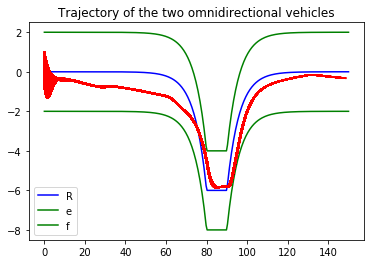

>>>>>>>>>>>>>>>>>>>>
Finished epoch 6
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Fi

Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solu

Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished i

Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished itera

Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 22
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished i

Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37

 1:  3.7654e-02 -8.4300e+00  2e+01  7e-01  6e+04
 2:  7.4001e-03 -4.1826e-01  8e-01  3e-02  3e+03
 3:  1.5725e-03 -2.2492e-02  4e-02  2e-03  2e+02
 4:  2.7125e-04 -1.5995e-03  3e-03  1e-04  1e+01
 5:  5.9754e-05 -2.4225e-04  5e-04  1e-05  1e+00
 6:  1.1705e-05 -2.9774e-05  6e-05  1e-06  1e-01
 7:  2.5263e-06 -4.2672e-06  9e-06  1e-07  1e-02
 8:  5.3037e-07 -6.8571e-07  1e-06  1e-08  1e-03
 9:  1.6298e-07 -2.2570e-07  5e-07  3e-09  3e-04
10:  2.7938e-08 -2.8348e-08  6e-08  3e-11  3e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  4.8769e-02 -7.1254e+00  1e+01  6e-01  5e+04
 2:  8.8711e-03 -5.6736e-01  1e+00  5e-02  4e+03
 3:  1.5447e-03 -2.9468e-02  6e-02  2e-03  2e+02
 4:  3.3532e-04 -2.4101e-03  5e-03  2e-04  1e+01
 5:  6.7668e-05 -2.7719e-04  6e-04  2e-05  2e+00
 6:  1.2373e-05 -2.8885e-05  6e-05  1e-06  1e-01
 7:  2.5857e-06 -4.1281e-06  8e-06  1e-07  1e-02
 8:  5.7663e-07 -7.4831e-0

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  3.0936e-02 -9.4966e+00  2e+01  8e-01  7e+04
 2:  6.2247e-03 -4.5203e-01  9e-01  4e-02  3e+03
 3:  1.1624e-03 -2.0405e-02  4e-02  2e-03  1e+02
 4:  2.3204e-04 -1.3955e-03  3e-03  1e-04  8e+00
 5:  4.7245e-05 -1.7782e-04  4e-04  1e-05  9e-01
 6:  9.1533e-06 -1.9578e-05  4e-05  8e-07  7e-02
 7:  1.8839e-06 -2.8903e-06  6e-06  8e-08  7e-03
 8:  4.5423e-07 -5.9234e-07  1e-06  1e-08  1e-03
 9:  1.2579e-07 -1.6334e-07  3e-07  3e-09  2e-04
10:  2.0894e-08 -2.1153e-08  4e-08  3e-11  2e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.3914e-02 -8.3600e+00  2e+01  7e-01  6e+04
 2:  4.2969e-03 -3.3603e-01  7e-01  3e-02  2e+03
 3:  9.2878e-04 -1.6796e-02  3e-02  1e-03  1e+02
 4:  1.9200e-04 -1.0806e-03  2e-03  7e-05  7e+00
 5:  3.8041e-05 -1.3578e-04  3e-04  8e-06  7e-01
 6:  7.5013e-06 -1.5337e-05

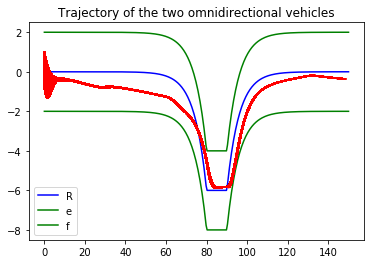

>>>>>>>>>>>>>>>>>>>>
Finished epoch 7
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Fi

Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solu

Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished i

Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished itera

Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 22
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished i

Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37

 1:  3.9196e-02 -8.3666e+00  2e+01  7e-01  6e+04
 2:  7.5473e-03 -4.0577e-01  8e-01  3e-02  3e+03
 3:  1.5783e-03 -2.2112e-02  4e-02  2e-03  2e+02
 4:  2.7066e-04 -1.5017e-03  3e-03  1e-04  9e+00
 5:  5.9916e-05 -2.3504e-04  5e-04  1e-05  1e+00
 6:  1.1948e-05 -3.0204e-05  6e-05  1e-06  1e-01
 7:  2.5533e-06 -4.2548e-06  9e-06  1e-07  1e-02
 8:  5.4092e-07 -6.9972e-07  1e-06  1e-08  1e-03
 9:  1.6669e-07 -2.3080e-07  5e-07  3e-09  3e-04
10:  2.8556e-08 -2.8979e-08  6e-08  3e-11  3e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  4.9584e-02 -7.3491e+00  2e+01  6e-01  5e+04
 2:  8.8977e-03 -5.8119e-01  1e+00  5e-02  4e+03
 3:  1.5683e-03 -3.4343e-02  7e-02  3e-03  2e+02
 4:  3.5219e-04 -2.7907e-03  6e-03  2e-04  2e+01
 5:  7.0113e-05 -2.9417e-04  6e-04  2e-05  2e+00
 6:  1.2539e-05 -2.9290e-05  6e-05  1e-06  1e-01
 7:  2.6098e-06 -4.1334e-06  8e-06  1e-07  1e-02
 8:  5.8144e-07 -7.5208e-0

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  3.1172e-02 -9.4696e+00  2e+01  8e-01  7e+04
 2:  6.2153e-03 -4.5449e-01  9e-01  4e-02  3e+03
 3:  1.1709e-03 -2.0381e-02  4e-02  2e-03  1e+02
 4:  2.3304e-04 -1.3947e-03  3e-03  1e-04  8e+00
 5:  4.7430e-05 -1.7764e-04  4e-04  1e-05  9e-01
 6:  9.1904e-06 -1.9626e-05  4e-05  8e-07  7e-02
 7:  1.8939e-06 -2.9054e-06  6e-06  8e-08  7e-03
 8:  4.5653e-07 -5.9532e-07  1e-06  1e-08  1e-03
 9:  1.2634e-07 -1.6407e-07  3e-07  3e-09  2e-04
10:  2.0986e-08 -2.1245e-08  4e-08  3e-11  2e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.3960e-02 -8.5302e+00  2e+01  7e-01  6e+04
 2:  4.3660e-03 -3.4890e-01  7e-01  3e-02  3e+03
 3:  9.4280e-04 -1.7299e-02  3e-02  1e-03  1e+02
 4:  1.9420e-04 -1.0808e-03  2e-03  7e-05  7e+00
 5:  3.8360e-05 -1.3681e-04  3e-04  8e-06  7e-01
 6:  7.5706e-06 -1.5433e-05

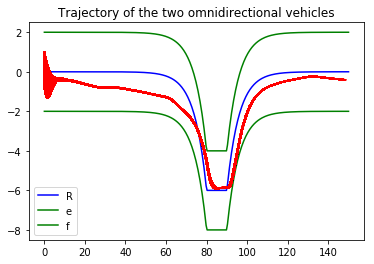

>>>>>>>>>>>>>>>>>>>>
Finished epoch 8
Optimize rajectory 0
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Fi

Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 6
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solu

Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 11
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished i

Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished itera

Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37 [Safe]
Finished iteration 38 [Safe]
Finished iteration 39 [Safe]
Finished iteration 40 [Safe]
Finished iteration 41 [Safe]
Finished iteration 42 [Safe]
Finished iteration 43 [Safe]
Finished iteration 44 [Safe]
Finished iteration 45 [Safe]
Finished iteration 46 [Safe]
Finished iteration 47 [Safe]
Finished iteration 48 [Safe]
Finished iteration 49 [Safe]
Optimize rajectory 22
Finished iteration 0 [Unsafe]
Finished iteration 1 [Safe]
Found new optimal solution. Load QP parameters.
Finished iteration 2 [Safe]
Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished i

Finished iteration 3 [Safe]
Finished iteration 4 [Safe]
Finished iteration 5 [Safe]
Finished iteration 6 [Safe]
Finished iteration 7 [Safe]
Finished iteration 8 [Safe]
Finished iteration 9 [Safe]
Finished iteration 10 [Safe]
Finished iteration 11 [Safe]
Finished iteration 12 [Safe]
Finished iteration 13 [Safe]
Finished iteration 14 [Safe]
Finished iteration 15 [Safe]
Finished iteration 16 [Safe]
Finished iteration 17 [Safe]
Finished iteration 18 [Safe]
Finished iteration 19 [Safe]
Finished iteration 20 [Safe]
Finished iteration 21 [Safe]
Finished iteration 22 [Safe]
Finished iteration 23 [Safe]
Finished iteration 24 [Safe]
Finished iteration 25 [Safe]
Finished iteration 26 [Safe]
Finished iteration 27 [Safe]
Finished iteration 28 [Safe]
Finished iteration 29 [Safe]
Finished iteration 30 [Safe]
Finished iteration 31 [Safe]
Finished iteration 32 [Safe]
Finished iteration 33 [Safe]
Finished iteration 34 [Safe]
Finished iteration 35 [Safe]
Finished iteration 36 [Safe]
Finished iteration 37

 1:  3.9586e-02 -6.9737e+00  1e+01  6e-01  5e+04
 2:  7.2192e-03 -3.3221e-01  7e-01  3e-02  2e+03
 3:  1.4965e-03 -1.9924e-02  4e-02  2e-03  1e+02
 4:  2.5940e-04 -1.3477e-03  3e-03  9e-05  8e+00
 5:  5.7819e-05 -2.2187e-04  4e-04  1e-05  1e+00
 6:  1.1686e-05 -2.8884e-05  6e-05  1e-06  1e-01
 7:  2.4529e-06 -3.9760e-06  8e-06  1e-07  1e-02
 8:  5.3897e-07 -7.0202e-07  1e-06  1e-08  1e-03
 9:  1.5977e-07 -2.1757e-07  4e-07  3e-09  3e-04
10:  2.7132e-08 -2.7523e-08  6e-08  3e-11  3e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  4.9583e-02 -7.1832e+00  1e+01  6e-01  5e+04
 2:  8.8241e-03 -5.5772e-01  1e+00  5e-02  4e+03
 3:  1.5767e-03 -3.3952e-02  7e-02  3e-03  2e+02
 4:  3.5218e-04 -2.8026e-03  6e-03  2e-04  2e+01
 5:  7.0351e-05 -2.9711e-04  6e-04  2e-05  2e+00
 6:  1.2593e-05 -2.9571e-05  6e-05  1e-06  1e-01
 7:  2.6124e-06 -4.1334e-06  8e-06  1e-07  1e-02
 8:  5.8360e-07 -7.5484e-0

     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  3.1973e-02 -9.4578e+00  2e+01  8e-01  7e+04
 2:  6.2329e-03 -4.6028e-01  9e-01  4e-02  3e+03
 3:  1.1803e-03 -2.0584e-02  4e-02  2e-03  1e+02
 4:  2.3482e-04 -1.4106e-03  3e-03  1e-04  9e+00
 5:  4.7610e-05 -1.7778e-04  4e-04  1e-05  9e-01
 6:  9.2359e-06 -1.9681e-05  4e-05  8e-07  7e-02
 7:  1.9099e-06 -2.9437e-06  6e-06  8e-08  7e-03
 8:  4.5778e-07 -5.9750e-07  1e-06  1e-08  1e-03
 9:  1.2403e-07 -1.6026e-07  3e-07  3e-09  2e-04
10:  2.0567e-08 -2.0815e-08  4e-08  3e-11  2e-06
Optimal solution found.
Starting solving QP
     pcost       dcost       gap    pres   dres
 0:  0.0000e+00  0.0000e+00  6e+02  2e+01  2e+06
 1:  2.3839e-02 -8.7080e+00  2e+01  8e-01  7e+04
 2:  4.3924e-03 -3.5178e-01  7e-01  3e-02  3e+03
 3:  9.4749e-04 -1.7415e-02  3e-02  1e-03  1e+02
 4:  1.9552e-04 -1.1045e-03  2e-03  8e-05  7e+00
 5:  3.8698e-05 -1.4008e-04  3e-04  8e-06  7e-01
 6:  7.6369e-06 -1.5725e-05

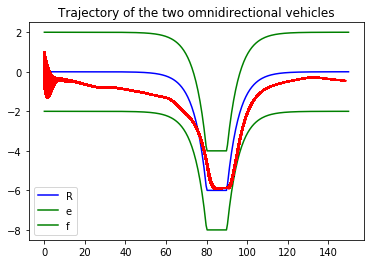

>>>>>>>>>>>>>>>>>>>>
Finished epoch 9


In [25]:
def QP(P_qp, q_qp, G_qp, h_qp, A_qp = None, b_qp = None):
    P_qp = numpy_sparse_to_spmatrix(P_qp)
    q_qp = matrix(q_qp)
    G_qp = numpy_sparse_to_spmatrix(G_qp)
    h_qp = matrix(h_qp)
    print("Starting solving QP")
    solvers.options['feastol'] = 1e-5
    sol=solvers.qp(P_qp, q_qp, G_qp, h_qp, A_qp, b_qp)
    #sol = {'x': [0.0 for i in range(dynamics.state_size * (N - n + 1) + agent.num_parameters(agent.model))]}
    theta_diffs = list(sol['x'])
    if theta_diffs is None:
        theta_diffs = np.zeros(agent.num_parameters(agent.model))
    return theta_diffs

#  # loop over the dataset multiple times 
agent_0 = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC', \
                      batch_size = 1000, \
                      checkpoint = checkpoint_0)

agent_traj_0 = agent_run(agent_0, x0s[:5])
draw_agent_traj(agent_traj_0)

agent = NeuralNetwork(input_size = (n + 1) * 4, \
                      model_name = 'mlp_H2_MPSC_', \
                      batch_size = 1000, \
                      checkpoint = 'checkpoints/mlp_H2_MPSC_95.pt')
agent_traj = agent_run(agent, x0s[:])
draw_agent_traj(agent_traj)

data_trajs = agent_traj

num_epoch = 10
tol = 1e-5

for epoch in range(num_epoch):
    num_itr = 50
    
    # Initialize Q matrix 
    Q1 = []
    Qx = []
    Qu = []
    Qx_T = []
    Qu_T = []
    Qxx = []
    Quu = []
    Qux = []
    Qxu = []

    # Initialize K, k
    K = []
    k = []

    # Run the latest model and original model to get (pi_\theta - u^*)
    u_diffs = []
    # Run the latest model to get gradient on the input x   
    pix = []
    # Run the latest model to get gradient on \theta
    pitheta = []

    # Barrier 1st order and 2nd order
    b1 = []
    bx = []
    bx_T = []
    bxx = []

    xs_diff = []
    us_diff = []
        
    h_qp = []
    G_qp = []
    
    theta_diffs = np.zeros([len(data_trajs), agent.num_parameters(agent.model)])
    P_qp = np.eye(agent.num_parameters(agent.model))
    q_qp = np.zeros([agent.num_parameters(agent.model), 1])
    

    
    for i_traj in range(len(data_trajs)):
        print("Optimize rajectory {}".format(i_traj))
        Q1.append(np.empty([len(data_trajs[i_traj]), 1, 1]))
        Qx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1])) 
        Qu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        Qx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size])) 
        Qu_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.action_size]))
        Qxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))
        Quu.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.action_size]))
        Qux.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        Qxu.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))

        # Initialize K, k
        K.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, dynamics.state_size]))
        k.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        # Run the latest model and original model to get (pi_\theta - u^*)
        u_diffs.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))
        # Run the latest model to get gradient on the input x   
        pix.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.action_size]))
        # Run the latest model to get gradient on \theta
        pitheta.append(np.empty([len(data_trajs[i_traj]), \
                                 agent.num_parameters(agent.model), dynamics.action_size]))

        # Barrier 1st order and 2nd order
        b1.append(np.empty([len(data_trajs[i_traj]), 1]))
        bx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        bx_T.append(np.empty([len(data_trajs[i_traj]), 1, dynamics.state_size]))
        bxx.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, dynamics.state_size]))

        xs_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.state_size, 1]))
        us_diff.append(np.empty([len(data_trajs[i_traj]), dynamics.action_size, 1]))

        h_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size, 1]))
        G_qp.append(np.zeros([len(data_trajs[i_traj]) * dynamics.action_size , \
                              agent.num_parameters(agent.model)]))
        
        data_traj_opt = data_trajs[i_traj][:]
        J_opt = len(data_trajs[i_traj]) * np.linalg.norm([2, 2], ord = 2)
        converged = False
        
        alpha = 1.
        mu = 1.
        
        for i_itr in range(num_itr):
            data_traj = data_trajs[i_traj][:]
            x_new = np.reshape([i for i in data_traj[0][0][:4]], [dynamics.state_size, 1])
            
            data_traj_tmp = []
            xs = []
            us = []
            
            agent.optimizer.zero_grad()
            J_new = 0.0
            
            for i_xy in range(len(data_traj)):
                x_y = data_traj[i_xy]
                x = np.reshape([i for i in x_y[0][:4]], [dynamics.state_size, 1])
                u = np.reshape([i for i in x_y[1][:]], [dynamics.action_size, 1])

                x_u = x - np.array([[0.0], [barrier_u(x[0, 0])[1]], [0.0], [0.0]])
                x_l = x - np.array([[0.0], [barrier_l(x[0, 0])[1]], [0.0], [0.0]])

                b1[i_traj][i_xy] = q1[0] * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) - q1[0]\
                        + q1[1] * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) - q1[1]
                bx[i_traj][i_xy] = q1[0] * q2[0]\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T + q1[1] * q2[1]\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T
                
                bx_T[i_traj][i_xy] = bx[i_traj][i_xy].T

                bxx[i_traj][i_xy] = q1[0] * q2[0]**2\
                    * np.exp(q2[0] * (A[0].dot(x_u) - b[0])) * A[0].T * A[0]\
                    + q1[1] * q2[1]**2\
                    * np.exp(q2[1] * (A[1].dot(x_l) - b[1])) * A[1].T * A[1]

                i = abs(int(x[0]/0.5))
                x_nn = []
                for j in [x[:, 0]] + x_nominal[i : i + H]:
                    for e in j:
                        x_nn.append(e)
                while len(x_nn) < 4 *(H + 1):
                    for e in x_nominal[-1]:
                        x_nn.append(e)

                x_nn = np.asarray(x_nn)
                x_input = torch.tensor([x_nn], requires_grad = True).float().to(agent.device)   
                u_output = agent.model(x_input)[0]
                
                for i in range(dynamics.action_size):
                    # Get gradient w.r.t input x[0:4] <<<< pix 
                    pix[i_traj][i_xy, :, i] = torch.autograd.grad(\
                    u_output[i], x_input, retain_graph = True)[0].cpu().numpy().T[0:dynamics.state_size, 0]

                    # Get gradient w.r.t model parameters theta <<<< g_theta
                    torch.autograd.backward(u_output[i], retain_graph = True)
                    j = 0
                    for theta in agent.model.parameters():
                        pitheta_ = theta.grad.data.flatten()
                        pitheta[i_traj][i_xy, j : j + pitheta_.size()[0], i] = pitheta_.cpu().numpy()
                        j += pitheta_.size()[0]    

                u_output = u_output.detach().cpu().numpy()
                u_output = np.reshape(u_output, [dynamics.action_size, 1])

                u_0 = agent_0.run([x_nn])[0]
                u_0 = np.reshape(u_0, [dynamics.action_size, 1])

                u_diffs[i_traj][i_xy] = u_output - u_0

                Q1[i_traj][i_xy] = 4 * b1[i_traj][i_xy]
                Qx[i_traj][i_xy] = -2 * pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy]) + \
                                    2 * bx[i_traj][i_xy]
                Qx_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T) + \
                                    2 * bx[i_traj][i_xy].T
                Qu[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy]
                Qu_T[i_traj][i_xy] = 2 * u_diffs[i_traj][i_xy].T

                Qxx[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(\
                                    u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T)) + 2 * bxx[i_traj][i_xy]
                Quu[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T) + \
                            mu * np.eye(Quu[i_traj][i_xy].shape[0])
                Qux[i_traj][i_xy] = u_diffs[i_traj][i_xy].dot(u_diffs[i_traj][i_xy].T.dot(pix[i_traj][i_xy].T))
                Qxu[i_traj][i_xy] = (pix[i_traj][i_xy].dot(u_diffs[i_traj][i_xy])).dot(u_diffs[i_traj][i_xy].T)

                K[i_traj][i_xy] = - np.linalg.pinv(Quu[i_traj][i_xy]).dot(Qux[i_traj][i_xy])
                k[i_traj][i_xy] = - np.linalg.pinv(Quu[i_traj][i_xy]).dot(Qu[i_traj][i_xy])

                x_diff = x_new - x

                us_diff[i_traj][i_xy] = alpha * k[i_traj][i_xy] + K[i_traj][i_xy].dot(x_diff)
                xs_diff[i_traj][i_xy] = x_diff
                
                u_new = u_output + us_diff[i_traj][i_xy]
                u_new = u_new.flatten().tolist()
                x_new = x_new.flatten().tolist()
                
                data_traj_tmp.append([x_new, u_new])
                xs.append(x_new)
                us.append(u_new)

                if i_xy < len(data_traj) - 1:
                    x_new = dynamics.f(xs[-1], us[-1], i_xy)[0]
                    x_new = np.reshape(x_new, x.shape)

            
            if (np.squeeze((np.asarray(xs) - \
                np.array([[x[0], barrier_u(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[0].T) - \
                           b[0,0] <= 0)).all() == True and \
               (np.squeeze((np.asarray(xs) - \
                np.array([[x[0], barrier_l(x[0])[1], 10.0, x[1]] for x in xs])).dot(A[1].T) - \
                           b[1,0] <= 0)).all() == True:
                print("Finished iteration {} [Safe]".format(i_itr))
                #draw_agent_traj([data_traj_tmp])
                
                for i_xy in range(u_diffs[i_traj].shape[0]):
                    J_new += np.linalg.norm(u_diffs[i_traj][i_xy], ord = 2)
                if J_opt > J_new:
                    if np.abs((J_opt - J_new)/J_opt) < tol:
                        converged = True
                        print("Converged.")
                        break
                    print("Found new optimal solution. Load QP parameters.")
                    for i_xy in range(len(data_traj)):
                        h_i = (us_diff[i_traj][i_xy].T - xs_diff[i_traj][i_xy].T.dot(pix[i_traj][i_xy])).T
                        G_i = pitheta[i_traj][i_xy].T

                        for j in range(dynamics.action_size):
                            h_qp[i_traj][i_xy + j, :] = h_i[j, 0]
                            G_qp[i_traj][i_xy + j, :] = G_i[j, :]
                    J_opt = J_new
                    data_traj_opt = data_traj_tmp[:]
                    
                alpha = 1.1 * (1.0 + 0.9**i_itr) * alpha 
                mu = 0.9 * (1.0 - 0.9**i_itr) * mu
                
            else:
                print("Finished iteration {} [Unsafe]".format(i_itr))   
                #draw_agent_traj([data_traj_tmp])
                alpha = 0.9 * (1 - 0.9**i_itr) * alpha
                mu = 1.1 * (1 + 0.9**i_itr) * mu 
        
        #data_trajs[i_traj] = data_traj_opt[:]
        #draw_agent_traj([data_traj_opt])
    
    
    pickle.dump((G_qp, h_qp), open('linear_eq.p', 'wb'))
    
    for i_traj in range(len(theta_diffs)):  
        theta_diffs[i_traj] = np.asarray(QP(P_qp, q_qp, G_qp[i_traj], h_qp[i_traj]))
    theta_diffs = np.mean(theta_diffs, axis = 0)
       
    
    #h_qp = np.concatenate(h_qp[:])
    #G_qp = np.concatenate(G_qp[:])
    #theta_diffs = linalg.cgs(G_qp.T.dot(G_qp), G_qp.T.dot(h_qp))[0]
    
    i = 0
    for theta in agent.model.parameters():
        theta.data += torch.FloatTensor(\
            np.reshape(theta_diffs[i: i + theta.data.numel()], theta.data.size())).to(agent.device)
        i += theta.data.numel()
        
    data_trajs = agent_run(agent, x0s)
    draw_agent_traj(data_trajs)
    print(">>>>>>>>>>>>>>>>>>>>")
    print("Finished epoch {}".format(epoch))
        

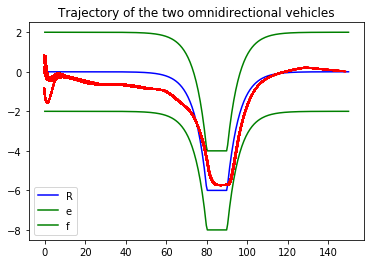

>>>>>>>>>>>>>>>>>>>>
Finished epoch 9


In [284]:
    
    for i_traj in range(num_itr):  
        theta_diffs[i_traj] = np.asarray(QP(P_qp, q_qp, G_qp[i_traj], h_qp[i_traj]))
    theta_diffs = np.mean(theta_diffs, axis = 0)
       
    
    #h_qp = np.concatenate(h_qp[:])
    #G_qp = np.concatenate(G_qp[:])
    #theta_diffs = linalg.cgs(G_qp.T.dot(G_qp), G_qp.T.dot(h_qp))[0]
    
    i = 0
    for theta in agent.model.parameters():
        theta.data += torch.FloatTensor(\
            np.reshape(theta_diffs[i: i + theta.data.numel()], theta.data.size())).to(agent.device)
        i += theta.data.numel()
        
    data_trajs_ = agent_run(agent, x0s)
    draw_agent_traj(data_trajs_)
    print(">>>>>>>>>>>>>>>>>>>>")
    print("Finished epoch {}".format(epoch))
    
